# Мэтчинг

## Описание проекта

Заказчику необходимо внедрить систему поиска товаров по запросу пользователя.

Имеются наборы данных уже преобразованных в эмбединги:
- База данных объектов (3 млн строк) - векторы размерностью 72
- Тренировочная выборка (100к строк) - векторы, имеющие лейблы (совпадающие товары из базы выше)
- Тестовая выборка, которая почему-то названа валидационной (100к строк) - векторы для проверки работы алгоритма

### Цель проекта

Найти алгоритм, который находит наиболее удачные совпадения из существующей базы.

Метрикой выбрана accuracy@5, то есть алгоритм отработал удачно, если из 5 результатов предоставлен релевантный.

Искать решение будем в 2 этапа:
- Посмотрим на результаты разных алгоритмов FAISS и выберем наиболее подходящий
- Выберем ранжирующий классификатор, который будет отбирать из n результатов выдачи 5 наиболее подходящих.

## Решение

### Импорт

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance as dist

import faiss

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.utils.class_weight import compute_class_weight

import time
import json
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

### Блок функций

In [2]:
def accuracy_n(target_df, idxs):
    '''
    принимает на вход таргеты и индексы
    возвращает метрику accuracy@n,
    где n - число соседей
    '''
    acc = 0
    for target, el in zip(target_df.values.tolist(), idxs.tolist()):
        acc += int(target in [base_index[r] for r in el])

    return(100 * acc / len(idxs))

def get_distances(vec_1, vec_2):
    '''
    принимает на вход 2 вектора, возвращает список расстояний
    '''
    distances = [
        dist.braycurtis(vec_1,vec_2),
        dist.canberra(vec_1,vec_2),
        dist.chebyshev(vec_1,vec_2),
        dist.cityblock(vec_1,vec_2), #Manhattan
        dist.correlation(vec_1,vec_2),
        dist.cosine(vec_1,vec_2),
        dist.euclidean(vec_1,vec_2),
        dist.minkowski(vec_1,vec_2,3),
        dist.minkowski(vec_1,vec_2,5)
    ]
    return distances

def make_features(candidates, query):
    '''
    принимает на вход:
    candidates - список индексов из base
    query - запрос (изначальный вектор)
    
    возвращает: список расстояний между изначальным запросом
    и каждым кандидатом
    '''
    distances = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base_array[candidate][mask]
        distances.append(get_distances(vec_1,vec_2))
    return np.array(distances)

def most_similar_5(arr):
    '''сортирует массив, полученный 
    из predict_proba и возвращает
    5 наиболее близких к 1
    '''
    return arr[:,0].argsort()[:5]

def make_concatenated(candidates, query, base):
    '''
    принимает на вход:
    candidates - список индексов из base
    query - запрос (изначальный вектор)
    base - массив для построения индекса
    
    возвращает: попарно сконкатенированные векторы
                из запроса с векторами кандидатов
    '''
    concatenated_vec = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base[candidate]
        concatenated_vec.append(np.concatenate([vec_1,vec_2]))
    return np.array(concatenated_vec)

def make_concatenated_with_distances(candidates, query, base):
    '''
    принимает на вход:
    candidates - список индексов из base
    query - запрос (изначальный вектор)
    base - массив для построения индекса
    
    возвращает: попарно сконкатенированные векторы
                из запроса с векторами кандидатов 
                и дистанциями между этими векторами
    '''
    concatenated_vecs = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base[candidate]
        concatenated_vec = np.concatenate([vec_1,vec_2])
        distances = get_distances(vec_1[mask], vec_2[mask])
        concatenated_vec = np.concatenate([concatenated_vec,distances])
        concatenated_vecs.append(concatenated_vec)
    return np.array(concatenated_vecs)

### Загрузка и осмотр данных

In [3]:
base_df = pd.read_csv('datasets/base.csv',index_col=0)
display(base_df.head())
print(base_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


(2918139, 72)


In [4]:
train_df = pd.read_csv('datasets/train.csv',index_col=0)
display(train_df.head())
print(train_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


(100000, 73)


In [5]:
validation_df = pd.read_csv('datasets/validation.csv',index_col=0)
display(validation_df.head())
print(validation_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


(100000, 72)


In [6]:
validation_answer_df = pd.read_csv('datasets/validation_answer.csv',index_col=0)
display(validation_answer_df.head())
print(validation_answer_df.shape)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


(100000, 1)


### EDA

Датасеты довольно объемные, признаков довольно много, поэтому полноценный EDA сделать проблематично.

Тем не менее, мы можем оценить:
- распределения признаков
- пропущенные значения
- дубликаты

#### Проверка на дубликаты

In [7]:
print('Дубликатов в base:', base_df.duplicated().sum())
print('Дубликатов в train:', train_df.duplicated().sum())
print('Дубликатов в validation:', validation_df.duplicated().sum())
print('Дубликатов в validation_answer:', validation_answer_df.duplicated().sum())

Дубликатов в base: 0
Дубликатов в train: 0
Дубликатов в validation: 0
Дубликатов в validation_answer: 8498


Есть дубликаты в ответах валидационного датафрейма. То есть некоторые векторы val_df имеют один и тот же ответ из base_df.
Пока не будем ничего с этим делать

#### Проверка на пропущенные значения

In [8]:
train_df.isna().sum().sum()

0

In [9]:
print('Пропущенных значений в base:', base_df.isna().sum().sum())
print('Пропущенных значений в train:', train_df.isna().sum().sum())
print('Пропущенных значений в validation:', validation_df.isna().sum().sum())
print('Пропущенных значений в validation_answer:', validation_answer_df.isna().sum().sum())

Пропущенных значений в base: 0
Пропущенных значений в train: 0
Пропущенных значений в validation: 0
Пропущенных значений в validation_answer: 0


Пропусков нет

#### Проверка распределений

Оценим визуально распределения в base_df. Чтобы не просчитывать 3 млн строк, сделаем это на основе выборки в 5%

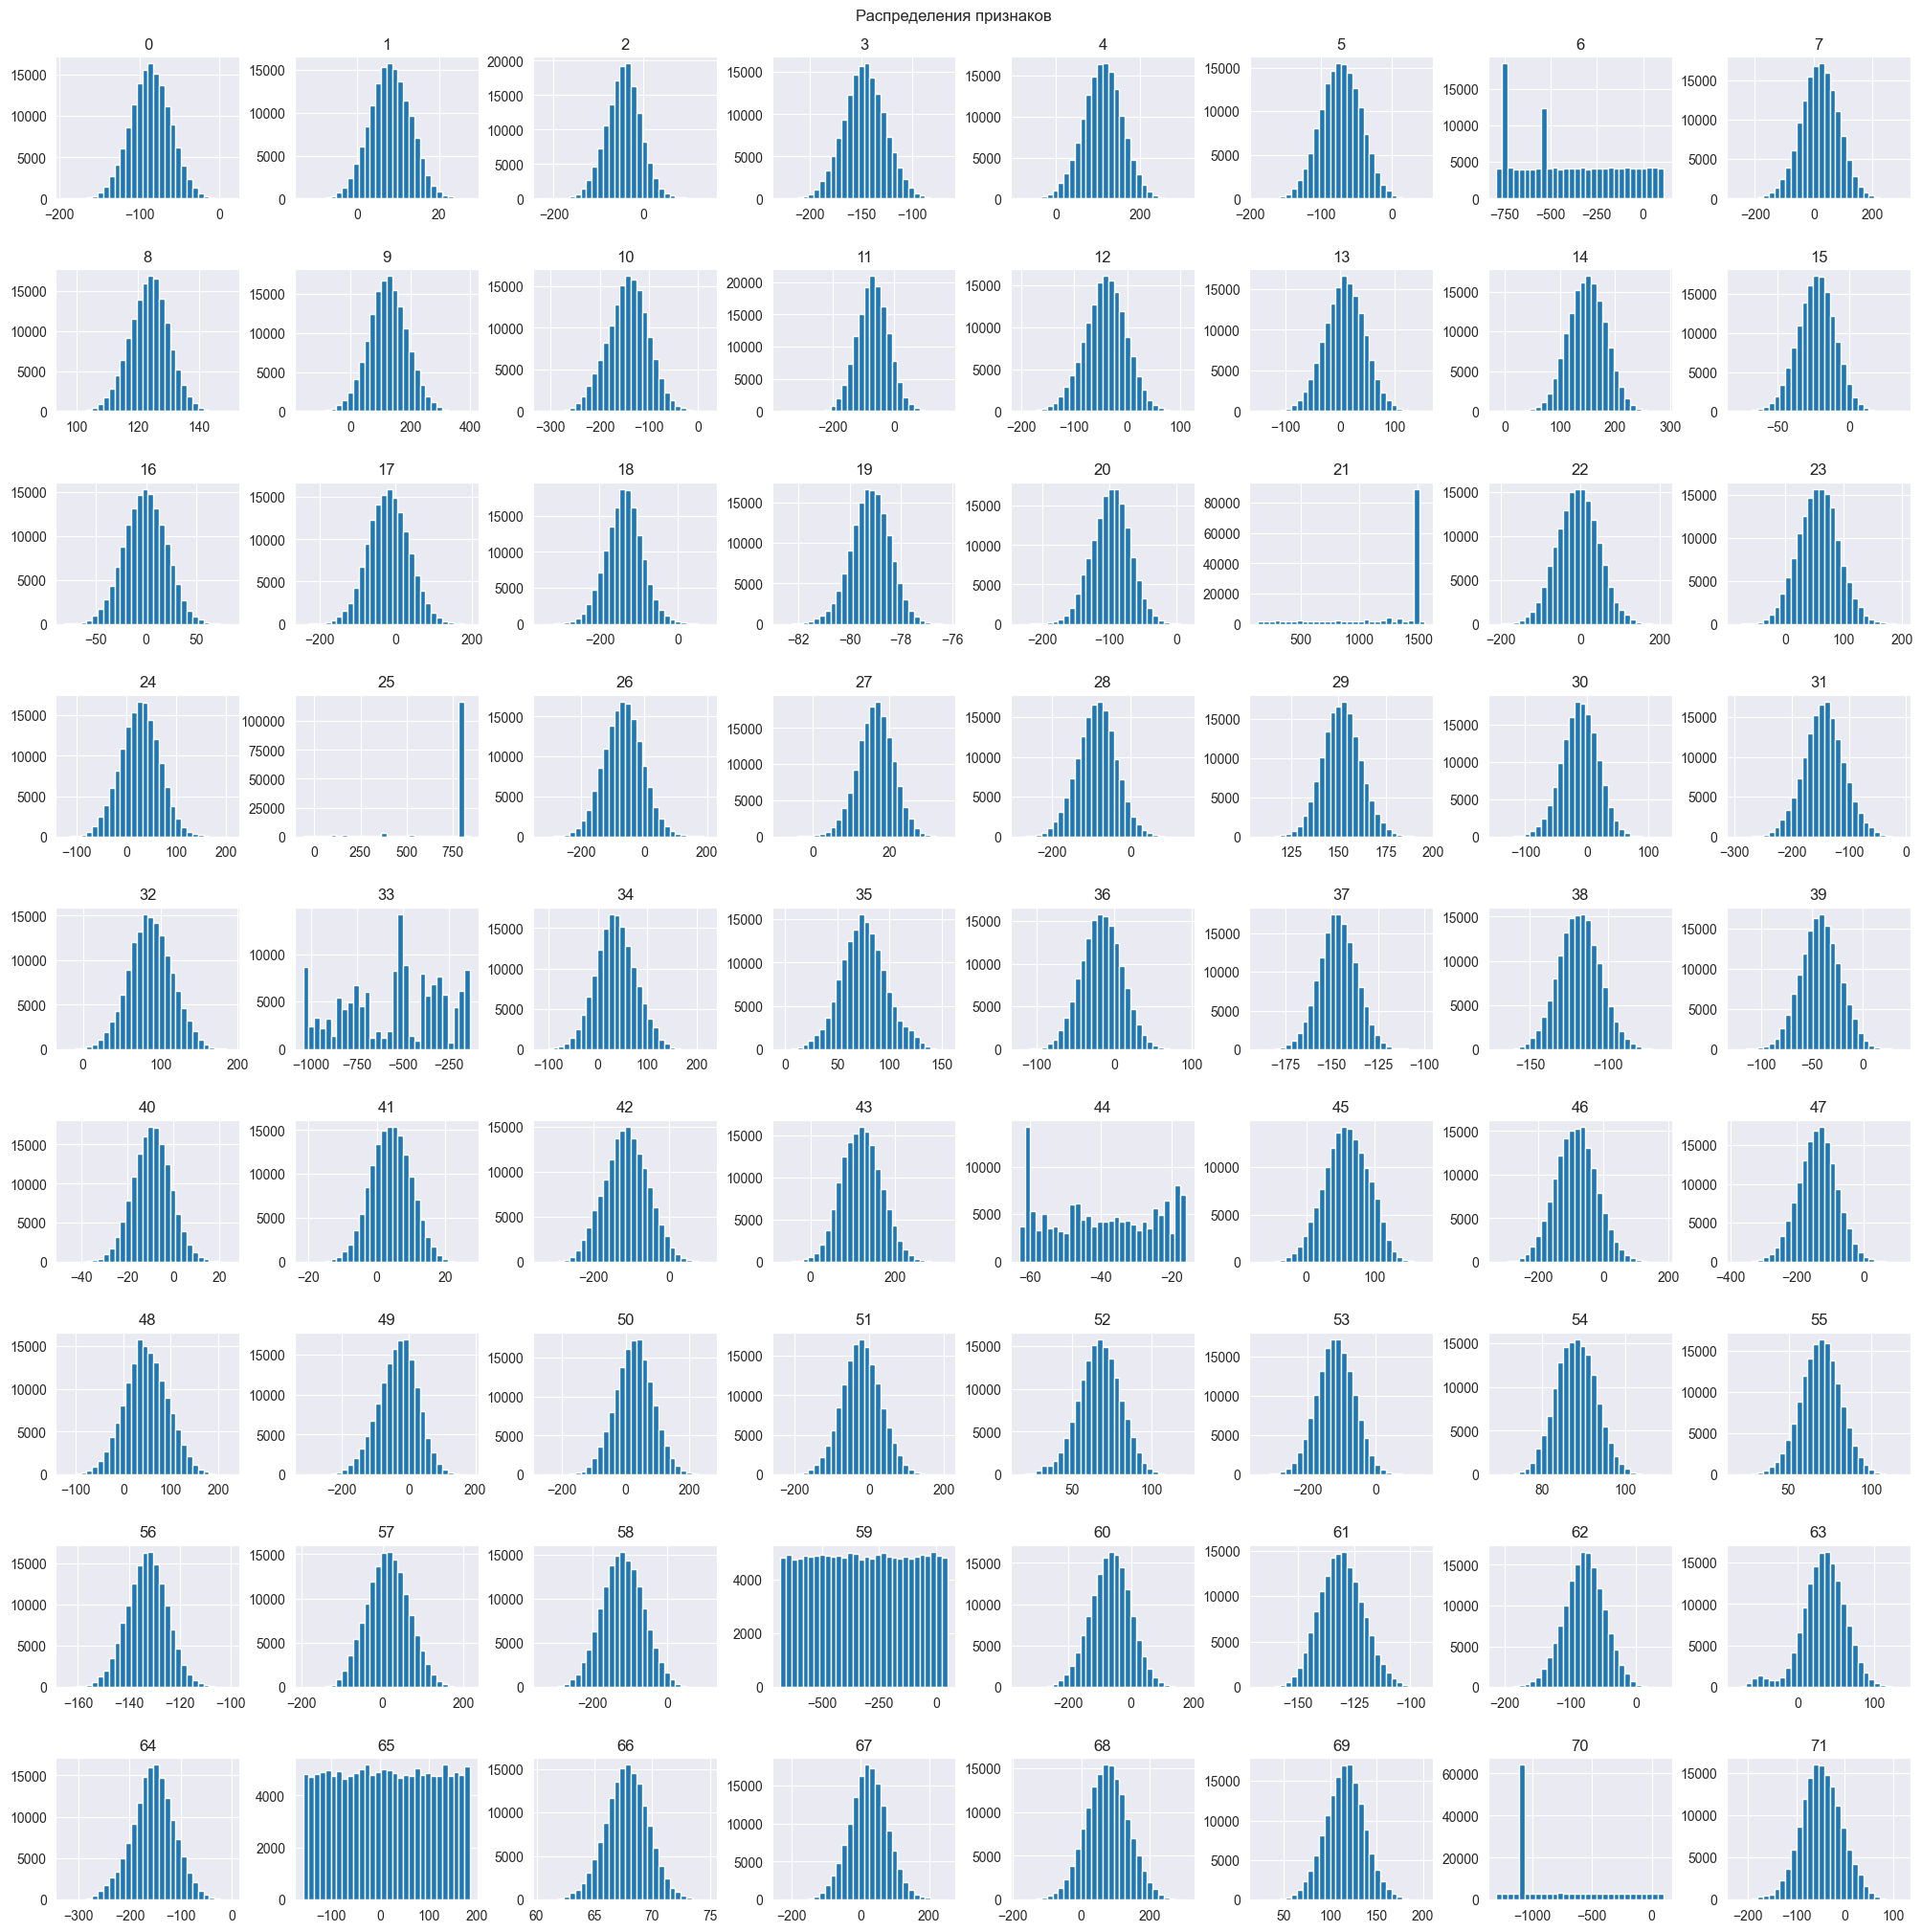

In [10]:
fig, axes = plt.subplots(nrows=9, ncols=8, figsize=(25,25))
fig.suptitle('Распределения признаков', y=0.9)
plt.subplots_adjust(hspace=0.5, wspace=0.3) # отодвигаем графики друг от друга
for i, col in enumerate(base_df.columns):
    ax = axes[i // 8, i % 8]
    ax.hist(x=base_df[col].sample(frac=0.05), bins=30)
    ax.set_ylabel('')
    ax.set_title(col)

Распределения некоторых признаков отличаются от нормального распределения. Значения признаков ненормированные, это нужно исправить.

Похоже, что ~~какой то джун испортил данные~~ в данные каким-то образом попали странные признаки

Составим список из `подозрительных` признаков. Проверим как модель будет работать с ними и без них. Если без них лучше, то удалим.

Всего признаков 72, подозратильных 8. Остается 64 признака. 

Для эмбедингов 72 признака - нетипичное значение, а 64 - типичное. Удаление этих признаков согласуется с логикой.

Но также эти признаки хорошо разделяют таргет, поэтому на этапе ранжирования их удалим, а на этапе работы ранжирующего классификатора - оставим

In [7]:
columns_to_drop = [str(i) for i in [6, 21, 25, 33, 44, 59, 65, 70]]

Что это за значения - неизвестно. Попробуем выявить взаимосвязь 

In [8]:
pd.concat([base_df.loc[train_df['Target']].reset_index(drop=True),train_df.reset_index(drop=True)], axis=1)[columns_to_drop]

,6,6,21,21,25,25,33,33,44,44,59,59,65,65,70,70
0,-347.360606,-347.360606,1507.231274,898.436927,813.770071,813.770071,-156.249890,-303.939233,-29.303956,-31.948470,4.452471,29.485587,56.448963,-101.965943,-415.750254,-415.750254
1,-530.528109,-94.572749,1507.231274,353.157741,813.770071,813.770071,-156.249890,-222.286354,-18.751057,-18.751057,-196.239966,-457.848461,85.860939,-1.638704,-1074.464888,-1035.092211
2,26.943937,26.943937,474.702613,1507.231274,813.770071,813.770071,-370.829232,-1018.469545,-30.211614,-30.211614,-339.338651,-163.120000,119.981731,82.144186,-1074.464888,-1074.464888
3,-775.150134,-775.150134,1507.231274,1507.231274,813.770071,813.770071,-481.586956,-1018.469545,-30.800995,-30.800995,-67.109047,-379.339090,7.052096,93.990981,-903.069010,-1074.464888
4,-321.317964,-321.317964,1507.231274,1507.231274,813.770071,813.770071,-188.960295,-780.449185,-53.147078,-53.147078,-48.663176,-203.212852,-117.626337,-117.626337,-1074.464888,-1074.464888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-203.447909,-514.276885,1507.231274,1507.231274,813.770071,813.770071,-1018.469545,-780.449185,-39.727996,-38.705081,2.519519,-497.646707,-113.342779,14.040794,-584.567615,-1074.464888
99996,-759.626065,-118.994688,1507.231274,1507.231274,813.770071,813.770071,-532.847888,-224.048030,-39.540199,-29.619612,-25.027777,-523.909110,-96.067057,-84.448525,-1074.464888,-1144.590904
99997,-427.544045,-427.544045,739.160725,739.160725,813.770071,813.770071,-289.045041,-505.853646,-33.539776,-33.539776,-257.409144,-630.989070,126.666121,22.971385,-714.897734,-714.897734
99998,-676.686800,-676.686800,1507.231274,1507.231274,813.770071,813.770071,-261.596067,-331.366174,-23.633237,-59.875136,-251.349583,-117.008985,100.064245,-93.810520,-370.828977,-1074.464888


Видно много совпадений. Возможно, случайность, но лучше проверить. Посчитаем суммы совпадений в `match` и в случайных

In [9]:
for i in columns_to_drop:
    print('Признак', i)
    print('Совпадений в match: ',
          (base_df.loc[train_df['Target']][i].reset_index(drop=True)\
           == train_df[i].reset_index(drop=True)).sum())
    print('Совпадений в случайных', 
          (base_df.sample(100_000)[i].reset_index(drop=True)\
           == train_df[i].reset_index(drop=True)).sum())
    print()

Признак 6
Совпадений в match:  64866
Совпадений в случайных 2471

Признак 21
Совпадений в match:  56705
Совпадений в случайных 38063

Признак 25
Совпадений в match:  79372
Совпадений в случайных 66357

Признак 33
Совпадений в match:  0
Совпадений в случайных 1662

Признак 44
Совпадений в match:  64752
Совпадений в случайных 588

Признак 59
Совпадений в match:  0
Совпадений в случайных 0

Признак 65
Совпадений в match:  29101
Совпадений в случайных 0

Признак 70
Совпадений в match:  71597
Совпадений в случайных 9479



Кажется, что по многим признакам можно очень хорошо разделить таргет. Выделяются 6,65,70,44 признаки. Поэтому поступим так:

- С помощью Faiss будем отделять без этих признаков(хотя проверим и с ними)
- Классификатор будет работать в т.ч. и с этими признаками. Удалять все не будем, вдруг присутствует нелинейная взаимосвязь

Делаем маску

In [10]:
mask = np.ones(72,dtype=bool)
mask[[int(i) for i in columns_to_drop]] = False
mask

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True])

План действий:
- Удалить странные признаки если без них метрика будет лучше
- Нормировать данные

### Предобработка данных и проверка работы FAISS

Данные уже разбиты на трейн и тест, выделяем таргеты. Также составляем словарь, где ключи - порядковые номера датафрейма `base_df` , значения - индекс(строка) в `base_df`

In [11]:
targets_train = train_df["Target"]
train_df.drop("Target", axis=1, inplace=True)
targets_val = validation_answer_df['Expected']
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}
base_index_inverted = {v:k for k,v in base_index.items()}

Составим индекс. Первым по рекомендациям разработчиков является IVF индекс с квантованием

Для начала пусть будет 1024 кластеров, по которым будет осуществляться поиск (число велико, но мы в будущем будем обходить несколько кластеров при поиске)

Увеличение числа кластеров дает бо'льшую производительность за счет точности.

Затем подберем этот гиперпараметр

In [12]:
dims = base_df.shape[1]
n_cells = 1024

Обучать индекс будем на 50000 векторов. Вероятно этого хватит, но нужно проверить.

Также составляем словарь, где ключи - порядковые номера датафрейма `base_df` , значения - индекс(строка) в `base_df`.

Вместо прописывания quantizer и index будем использовать укороченную запись при помощи `index_factory`

In [17]:
index = faiss.index_factory(dims, 'IVF1024,Flat') #quantizer c 1024 ячейками, Flat индекс с l2 метрикой
index.train(np.ascontiguousarray(base_df.values[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_df.values).astype('float32'))

In [18]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_df.values).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 17 s
Wall time: 3.23 s


4.244

Accuracy@5 чуть выше 4%. Стандартизируем векторы и запустим алгоритм заново

In [13]:
scaler = StandardScaler()
base_array = scaler.fit_transform(base_df)
train_array = scaler.transform(train_df)
validation_array = scaler.transform(validation_df)

In [20]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

In [21]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 21.8 s
Wall time: 4.06 s


50.394

Алгоритм отработал за 4 с небольшим секунды. Стандартизация заметно улучшает метрику.

Удалим подозрительные столбцы и проверим результат.

In [14]:
dims = base_array[:,mask].shape[1] #размерность векторов изменилась, переопределим переменную

In [23]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50000, mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))

In [24]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 18.9 s
Wall time: 3.67 s


61.076

Удаление `подозрительных` признаков улучшило метрику.

Попробуем увеличить количество кластеров для поиска `nprobe`. Время работы алгоритма при этом должно увеличиться. Предполагаю, что этот гиперпараметр будет иметь схожий эффект с гиперпараметром `n_cells` - перебор бо'льшего числа векторов при увеличении времени работы.

Заодно, для успокоения души проверим действительно ли хватает 50_000 образцов для обучения индекса. Попробуем 500_000

In [25]:
%%time
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:500_000, mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.nprobe = 32

CPU times: total: 24 s
Wall time: 5.53 s


In [26]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 6min 39s
Wall time: 1min 12s


70.408

In [27]:
%%time
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50_000, mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.nprobe = 32

CPU times: total: 16.2 s
Wall time: 4.33 s


In [28]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 7min 1s
Wall time: 1min 21s


70.419

2 метрики выше почти полностью совпадают. 50к достаточно для экспериментов с индексами(у многих из них увеличивается время обучения в зависимости от размера выборки), но для финальной модели будем использовать полный набор

Резюмируем:
- Больше кластеров по которым ищем - точнее поиск (т.к. правильный результат может быть в соседнем кластере). Время работы увеличивается линейно (на самом деле чуть быстрее, видимо, внутри лежат эффективные алгоритмы)
- 50к образцов для обучения достаточно
- Стандартизация сильно улучшает метрику

### Дальнейший план работы

Что делаем дальше. 

По уверениям разработчиков `Flat` индекс является довольно точным. Поэтому проведем эксперименты с различными гиперпараметрами этого индекса.
Но полностью на слово доверять не будем и проверим также другие индексы, если увидим результаты лучше, то проведем подбор гиперпараметров и для них тоже

Проверим следующий алгоритм:

Находим оптимальные гиперпараметры:
- Увеличиваем количество результатов поиска - от 5 до выхода на плато. `accuracy_n` увеличится, но осложнится последующая задача ранжирования.
- Увеличиваем nprobe - тут время будет расти линейно, получаем trade между скоростью работы и точностью алгоритма



Ранжируем результаты:
- Находим расстояния от каждого вектора из query с каждым вектором из выдачи. То же самое проделываем для валидационной выборки
- В качестве таргета добавляем лейбл 1 или 0. Делаем так для каждого вектора из query, в итоге получаем датасет из 100_000 * idxs.shape[1] строк
- Обучаем ml-модели для нахождения 1 на трейне. На выдаче получаем скоры. Следим за переобучением на валидационной выборке.
- Первые 5 скоров и будут результатом выдачи, по которым будет считаться метрика.



### Подбор гиперпараметров для FAISS

Реализуем первый шаг - найдем гиперпараметры для faiss
Пройдемся вложенным циклом и упакуем результаты в словарь. Струкрура словаря
```
metrics = {
    '5 соседей':{
        '1 кластер': [время_5_1, accuracy_train, accuracy_val], 
        '2 кластера': [время_5_2, accuracy_train, accuracy_val],
        ...,
        '128 кластеров': [время_5_2, accuracy_train, accuracy_val]
    },
    '10 соседей':{
        '1 кластер': [время_10_1, accuracy_train, accuracy_val], 
        '2 кластера': [время_10_2, accuracy_train, accuracy_val],
        ...,
        '128 кластеров': [время_10_2, accuracy_train, accuracy_val]
    },
    ...
}
```

In [15]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:, mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))

In [ ]:
metrics = {}
c = time.time()
for neighbours in range(5,101,5): #ищем от 5 до 100 соседей
    metrics[neighbours] = {}
    for nprobe in [2**x for x in range(6)]: #ищем в разном числе кластеров
        a = time.time()
        index.nprobe = nprobe
        distances_train, idxs_train = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), neighbours)
        for i,v in enumerate(idxs_train): #заменяем -1 в ответах на 0
            if -1 in v:
                idxs_train[i] = np.array([idx if idx != -1 else 0 for idx in v])
        
        distances_val, idxs_val = index.search(np.ascontiguousarray(validation_array[:,mask]).astype('float32'), neighbours)
        for i,v in enumerate(idxs_val):
            if -1 in v:
                idxs_val[i] = np.array([idx if idx != -1 else 0 for idx in v])
            
        b = time.time()
#         отслеживаем прогресс поиска гиперпараметров с обновляемым выводом
        print((f'\rОбработан запрос: neighbours = {neighbours},'
               f'nprobe = {nprobe}, общее время выполнения {b-c:.2f} секунд'), end='')
        metrics[neighbours][nprobe] = [f'Затраченное время = {(b-a)/2:.2f} секунд',\
                                       accuracy_n(targets_train, idxs_train), accuracy_n(targets_val, idxs_val)]

Чтобы не запускать ячейку выше - сохраним результаты экспериментов в json-файл. Саму ячейку пока закомментируем (в репозитории будет раскомментирована, выполняется долго)

Вывод ячейки:
Обработан запрос: neighbours = 100,nprobe = 32, общее время выполнения 6775.33 секунд

In [31]:
# with open('datasets/metrics_faiss.json', "w", encoding="utf-8") as file:
#     json.dump(metrics, file)

In [32]:
metrics = json.load(open('datasets/metrics_faiss.json'))
metrics

{'5': {'1': ['Затраченное время = 3.71 секунд', 59.733, 59.902],
  '2': ['Затраченное время = 6.52 секунд', 65.091, 65.126],
  '4': ['Затраченное время = 11.72 секунд', 67.644, 67.735],
  '8': ['Затраченное время = 21.78 секунд', 69.125, 69.108],
  '16': ['Затраченное время = 41.04 секунд', 69.938, 69.949],
  '32': ['Затраченное время = 79.44 секунд', 70.392, 70.35]},
 '10': {'1': ['Затраченное время = 3.70 секунд', 61.364, 61.501],
  '2': ['Затраченное время = 6.55 секунд', 67.087, 67.047],
  '4': ['Затраченное время = 11.79 секунд', 69.904, 69.944],
  '8': ['Затраченное время = 21.48 секунд', 71.57, 71.539],
  '16': ['Затраченное время = 39.36 секунд', 72.518, 72.536],
  '32': ['Затраченное время = 75.66 секунд', 73.055, 73.032]},
 '15': {'1': ['Затраченное время = 3.57 секунд', 62.127, 62.259],
  '2': ['Затраченное время = 6.35 секунд', 68.007, 67.99],
  '4': ['Затраченное время = 11.27 секунд', 70.936, 70.996],
  '8': ['Затраченное время = 20.81 секунд', 72.706, 72.709],
  '16': ['

Валидация сильно не отличается. Вероятно, распределение train и val схожи. Построим графики по трейну.

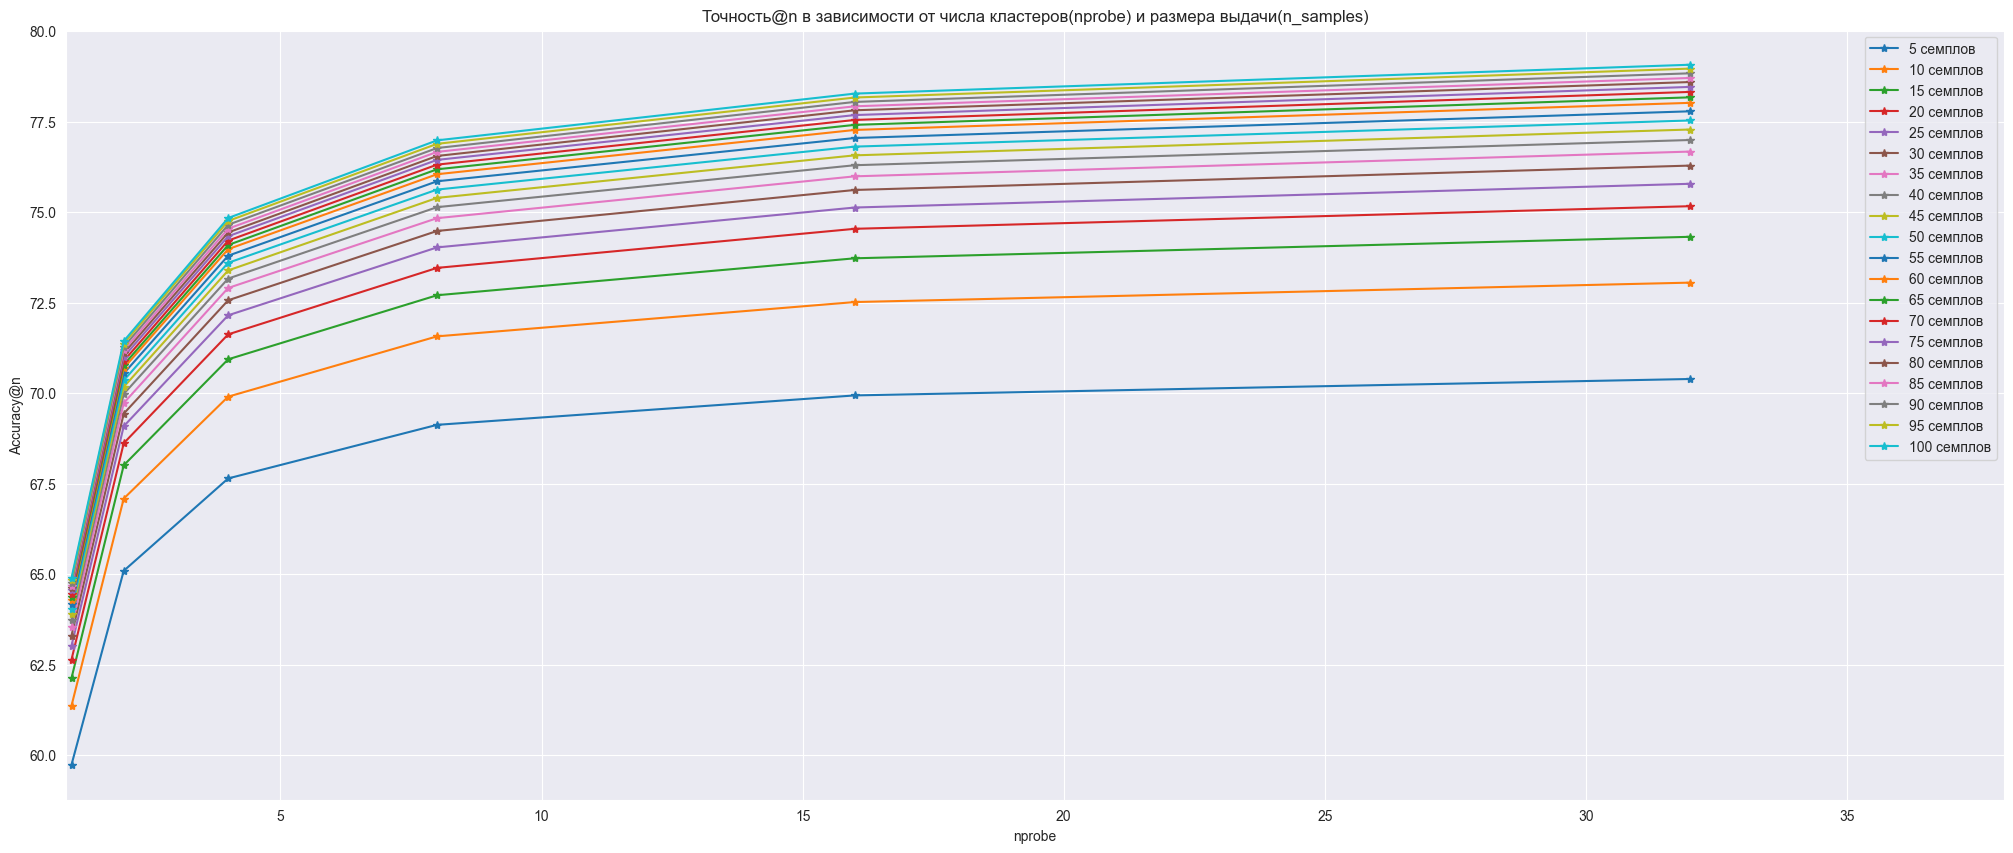

In [33]:
fig, ax = plt.subplots(1, figsize=(25, 10))
for n_samples in metrics.keys():
    y = [i[1] for i in metrics[n_samples].values()]
    x = [int(i) for i in metrics[n_samples].keys()]
    ax.plot(x,y, marker='*', label=f'{n_samples} семплов')
plt.xlim(0.9, 38)
plt.ylabel('Accuracy@n')
plt.xlabel('nprobe')
plt.title('Точность@n в зависимости от числа кластеров(nprobe) и размера выдачи(n_samples)')
ax.legend()
plt.show()

Выдача бо'льшего количества семплов не увеличивает время, но, вероятно, будет ухудшать результаты модели ранжирования (гораздо проще отобрать 5 правильных кандидатов из 30 семплов, чем 5 кандидатов из 100 семплов)

С увеличением nprobe время увеличивается линейно. Поиск по 32 кластерам не дает ощутимого прироста. 40 секунд - ок, 1,5 минуты уже долго. поэтому оставляем nprobe 16. Но если ресурсы позволят запустить в прод модель потяжелее - запустим хоть 1024(перемножим все вектора со всеми)

### Поиск оптимального индекса для задачи (раздел создан для экспериментов и не внес существенного value, можно пропустить)

Мы рассмотрели только Flat индекс с разбиением на кластеры. Посмотрим другие индексы. 

По хорошему нужно перебрать множество гиперпараметров, но в цикле по примеру выше это делать долго. Поэтому некоторые эксперименты оставлены `за кадром`. Оценивать будем с полученным бенчмарком в т.ч. и по скорости работы.

Сравнивать будем по 50 соседям и nprobe 16

In [34]:
metrics['50']['16']

['Затраченное время = 39.28 секунд', 76.813, 76.808]

#### IndexFlatIP

In [16]:
quantizer = faiss.IndexFlatIP(dims)
index = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [17]:
%%time
index.train(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.nprobe = 16

CPU times: total: 29.7 s
Wall time: 8.06 s


In [18]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 5min 4s
Wall time: 58.3 s


77.094

- Обучение индекса быстрое.
- Результат по сравнимому `nprobe` лучше, чем у бенчмарка
- Но за это же время мы можем перебрать в 2 раза больше кластеров у бенчмарка и получить метрику лучше

Вывод: индекс показал себя хуже

#### IVFADC Индекс

In [19]:
%%time
index = faiss.index_factory(dims, 'IVF1024,PQ16')
index.train(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.nprobe = 16

CPU times: total: 1min 47s
Wall time: 23.4 s


In [20]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 49.5 s
Wall time: 10.9 s


76.695

- Обучение индекса длится дольше.
- Результат по сравнимому `nprobe` хуже, чем у бенчмарка.
- Работает в 3 раза быстрее, можем перебрать больше кластеров за сопоставимое время

Вывод: кандидат на замену бенчмарку

#### HNSWFlat Индекс

Разработчики рекомендуют использовать индекс для 1М-10М датасетов. Как раз наш случай. Проверим

In [21]:
%%time
index = faiss.index_factory(dims,'IVF1024_HNSW32,Flat')
index.train(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))

CPU times: total: 52.9 s
Wall time: 12.4 s


In [22]:
index.nprobe = 16

In [23]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 50)

CPU times: total: 3min 38s
Wall time: 40.5 s


In [24]:
accuracy_n(targets_train, idxs)

76.222

- Обучение заметно дольше
- Результат приблизительно тот же
- Время поиска немного дольше

Вывод: не подходит на замену, возможно, требует больше экспериментов

#### HNSW

Этот индекс быстрее. efSearch зададим больше чем 16

In [25]:
%%time
index = faiss.index_factory(dims,'HNSW')
index.train(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))

CPU times: total: 13min 26s
Wall time: 2min 30s


In [26]:
index.hnsw.efSearch = 512

In [27]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 2min 45s
Wall time: 32.5 s


76.202

- Долгое обучение индекса
- Результат хуже
- Время поиска немного быстрее

Вывод: возможно, требует больше экспериментов

Общий вывод:

Пока будем использовать Flat индекс с 1024 кластерами. Если останется время - поэкспериментируем еще

In [28]:
del base_df
del train_df
del validation_df

### Ранжирование результатов

Для ранжирования результатов будем использовать классификатор с методом `predict_proba`. Нужно научить классификатор правильно определять совпадающие товары.

- Пока не будем заниматься подбором гиперпараметров (пусть даже переобучимся!), а просто поэкспериментируем. 
- Т.к. из результатов мы будем вытягивать скоры, а не 1 и 0, то максимизируем `roc-auc`

Далее идут эксперименты с 4 подходами.

Пропустить эксперименты и перейти к подходу, который дал результат можно [Тут](#title1)

#### Множества результатов для разного числа соседей, для генерации обучающей выборки и валидации результатов

In [48]:
index = faiss.index_factory(dims,'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.nprobe = 32

Это нижний порог. Если итоговое значение выше нижнего порога, то ранжирование удалось

На этих векторах будем учить классификатор

In [49]:
%%time
_, idxs_50 = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 50)
accuracy_n(targets_train, idxs_50)

CPU times: total: 6min 49s
Wall time: 1min 16s


77.616

In [50]:
%%time
_, idxs_val_50 = index.search(np.ascontiguousarray(validation_array[:,mask]).astype('float32'), 50)
accuracy_n(targets_val, idxs_val_50)

CPU times: total: 6min 48s
Wall time: 1min 15s


77.487

Это наш верхний порог. Можно и больше, но генерить обучающую выборку будет сложнее - упремся в память

In [59]:
print(accuracy_n(targets_train, idxs_50[:,:10]))
print(accuracy_n(targets_val, idxs_val_50[:,:10]))

73.129
73.036


На этих векторах будем учить классификатор

In [60]:
print(accuracy_n(targets_train, idxs_50[:,:5]))
print(accuracy_n(targets_val, idxs_val_50[:,:5]))

70.474
70.349


Нижний порог. Результаты хуже этого означают, что классификатор только ухудшает работу

#### Подход с расстояниями до рандомных векторов

Для ранжирования результатов будем использовать классификатор с методом `predict_proba`. Нужно научить классификатор правильно определять совпадающие товары.

- Составим обучающий датасет, в котором посчитаем расстояния от искомого вектора до совпадающего вектора. Проставим лейбл 1
- Добавим в датасет расстояния от искомого вектора до рандомного вектора base_array. Проставим лейбл 0.

Данные разобьем 80/20, на 20% считаем метрику.
- Для каждого алгоритма посмотрим на результат ранжирования на трейне! Почему не на валидационной? 
    - Потому что векторы, которые будут сгенерированы Faiss'ом будут отличаться от фичей, которые мы сгенерировали 
    - Потому что если алгоритм не покажет себя даже на тренировочной выборке, то нет никакого смысла смотреть валидационную.
- Увидим результат - будем тюнить с помощью кросс-валидации, следить за переобучением и смотреть на валидацию (то есть будем считать нашу валидационную выборку тестовой)

Спойлер:
такая выборка слишком простая и классификатор ничему не научится

In [107]:
features = []
target = []
for vec_1, index_target in tqdm(zip(train_array, targets_train.values)):
    vec_2 = base_array[base_index_inverted[index_target]]
    distance_list = get_distances(vec_1[mask], vec_2[mask])
    features.append(distance_list)
    target.append(1)
    vec_3 = base_array[np.random.randint(base_array.shape[0])]
    distance_list = get_distances(vec_1[mask], vec_3[mask])
    features.append(distance_list)
    target.append(0)
features = np.array(features)
target = np.array(target)

100000it [00:39, 2513.13it/s]


In [108]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2, 
                                                    random_state=42)

##### LogisticRegression

In [109]:
model = LogisticRegression(max_iter=10000)
model.fit(x_train,y_train)

LogisticRegression(max_iter=10000)

In [110]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.9830846259379863
0.9830936375663782


Теперь вычислим расстояния от искомого вектора до каждого из 10 соседей. Выделим 5 наиболее близких и проверим метрику

In [111]:
result = []
for i, candidates in tqdm(enumerate(idxs_50[:,:10])):
    query = train_array[i][mask] #искомый вектор
    query_features = make_features(candidates, query) #массив с расстояниями
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_train, np.array(result))

100000it [03:30, 474.04it/s]


70.539

Вывод:

Метрика для отранжированных 10 кандидатов даже на трейне сопоставима с простым поиском по 5 кандидатам. Плюс затрачено 3,5 минуты времени на генерацию фич и работу модели. 

Такой подход не годится. За те же самые 3,5 минуты мы могли бы обойти в несколько раз больше кластеров в индексе и получить метрику выше.

##### CatBoostClassifier

In [112]:
model = CatBoostClassifier(
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_state=42
)

eval_data = Pool(
    data=x_test,
    label=y_test
)

model.fit(x_train,y_train, eval_set=eval_data)

Learning rate set to 0.111001
0:	test: 0.9748217	best: 0.9748217 (0)	total: 17.8ms	remaining: 17.8s
1:	test: 0.9817014	best: 0.9817014 (1)	total: 38.7ms	remaining: 19.3s
2:	test: 0.9829249	best: 0.9829249 (2)	total: 56.4ms	remaining: 18.7s
3:	test: 0.9832708	best: 0.9832708 (3)	total: 74ms	remaining: 18.4s
4:	test: 0.9834130	best: 0.9834130 (4)	total: 92.6ms	remaining: 18.4s
5:	test: 0.9834985	best: 0.9834985 (5)	total: 111ms	remaining: 18.5s
6:	test: 0.9835488	best: 0.9835488 (6)	total: 131ms	remaining: 18.6s
7:	test: 0.9836983	best: 0.9836983 (7)	total: 153ms	remaining: 19s
8:	test: 0.9838714	best: 0.9838714 (8)	total: 172ms	remaining: 19s
9:	test: 0.9838355	best: 0.9838714 (8)	total: 190ms	remaining: 18.9s
10:	test: 0.9839722	best: 0.9839722 (10)	total: 212ms	remaining: 19s
11:	test: 0.9839920	best: 0.9839920 (11)	total: 229ms	remaining: 18.9s
12:	test: 0.9840039	best: 0.9840039 (12)	total: 246ms	remaining: 18.7s
13:	test: 0.9840353	best: 0.9840353 (13)	total: 263ms	remaining: 18.5s

117:	test: 0.9847507	best: 0.9847705 (93)	total: 1.94s	remaining: 14.5s
118:	test: 0.9847550	best: 0.9847705 (93)	total: 1.96s	remaining: 14.5s
119:	test: 0.9847524	best: 0.9847705 (93)	total: 1.97s	remaining: 14.5s
120:	test: 0.9847553	best: 0.9847705 (93)	total: 1.99s	remaining: 14.4s
121:	test: 0.9847585	best: 0.9847705 (93)	total: 2s	remaining: 14.4s
122:	test: 0.9847639	best: 0.9847705 (93)	total: 2.02s	remaining: 14.4s
123:	test: 0.9847624	best: 0.9847705 (93)	total: 2.04s	remaining: 14.4s
124:	test: 0.9847573	best: 0.9847705 (93)	total: 2.05s	remaining: 14.4s
125:	test: 0.9847560	best: 0.9847705 (93)	total: 2.07s	remaining: 14.3s
126:	test: 0.9847520	best: 0.9847705 (93)	total: 2.08s	remaining: 14.3s
127:	test: 0.9847566	best: 0.9847705 (93)	total: 2.1s	remaining: 14.3s
128:	test: 0.9847624	best: 0.9847705 (93)	total: 2.12s	remaining: 14.3s
129:	test: 0.9847636	best: 0.9847705 (93)	total: 2.14s	remaining: 14.3s
130:	test: 0.9847649	best: 0.9847705 (93)	total: 2.16s	remaining: 14

236:	test: 0.9847098	best: 0.9847705 (93)	total: 3.86s	remaining: 12.4s
237:	test: 0.9847190	best: 0.9847705 (93)	total: 3.88s	remaining: 12.4s
238:	test: 0.9847172	best: 0.9847705 (93)	total: 3.89s	remaining: 12.4s
239:	test: 0.9847139	best: 0.9847705 (93)	total: 3.91s	remaining: 12.4s
240:	test: 0.9847191	best: 0.9847705 (93)	total: 3.92s	remaining: 12.4s
241:	test: 0.9847217	best: 0.9847705 (93)	total: 3.94s	remaining: 12.3s
242:	test: 0.9847227	best: 0.9847705 (93)	total: 3.95s	remaining: 12.3s
243:	test: 0.9847227	best: 0.9847705 (93)	total: 3.97s	remaining: 12.3s
244:	test: 0.9847227	best: 0.9847705 (93)	total: 3.98s	remaining: 12.3s
245:	test: 0.9847226	best: 0.9847705 (93)	total: 4s	remaining: 12.3s
246:	test: 0.9847218	best: 0.9847705 (93)	total: 4.01s	remaining: 12.2s
247:	test: 0.9847206	best: 0.9847705 (93)	total: 4.03s	remaining: 12.2s
248:	test: 0.9847206	best: 0.9847705 (93)	total: 4.04s	remaining: 12.2s
249:	test: 0.9847214	best: 0.9847705 (93)	total: 4.06s	remaining: 1

359:	test: 0.9847030	best: 0.9847705 (93)	total: 5.55s	remaining: 9.86s
360:	test: 0.9847030	best: 0.9847705 (93)	total: 5.56s	remaining: 9.84s
361:	test: 0.9847030	best: 0.9847705 (93)	total: 5.57s	remaining: 9.82s
362:	test: 0.9847030	best: 0.9847705 (93)	total: 5.58s	remaining: 9.8s
363:	test: 0.9847030	best: 0.9847705 (93)	total: 5.6s	remaining: 9.78s
364:	test: 0.9847030	best: 0.9847705 (93)	total: 5.61s	remaining: 9.76s
365:	test: 0.9847030	best: 0.9847705 (93)	total: 5.62s	remaining: 9.74s
366:	test: 0.9847030	best: 0.9847705 (93)	total: 5.64s	remaining: 9.72s
367:	test: 0.9847030	best: 0.9847705 (93)	total: 5.65s	remaining: 9.7s
368:	test: 0.9847030	best: 0.9847705 (93)	total: 5.66s	remaining: 9.68s
369:	test: 0.9847030	best: 0.9847705 (93)	total: 5.67s	remaining: 9.66s
370:	test: 0.9847030	best: 0.9847705 (93)	total: 5.69s	remaining: 9.64s
371:	test: 0.9847030	best: 0.9847705 (93)	total: 5.7s	remaining: 9.62s
372:	test: 0.9847030	best: 0.9847705 (93)	total: 5.71s	remaining: 9.

476:	test: 0.9847030	best: 0.9847705 (93)	total: 7.04s	remaining: 7.72s
477:	test: 0.9847030	best: 0.9847705 (93)	total: 7.06s	remaining: 7.71s
478:	test: 0.9847030	best: 0.9847705 (93)	total: 7.07s	remaining: 7.69s
479:	test: 0.9847030	best: 0.9847705 (93)	total: 7.08s	remaining: 7.67s
480:	test: 0.9847030	best: 0.9847705 (93)	total: 7.09s	remaining: 7.66s
481:	test: 0.9847030	best: 0.9847705 (93)	total: 7.11s	remaining: 7.64s
482:	test: 0.9847030	best: 0.9847705 (93)	total: 7.12s	remaining: 7.62s
483:	test: 0.9847030	best: 0.9847705 (93)	total: 7.13s	remaining: 7.6s
484:	test: 0.9847030	best: 0.9847705 (93)	total: 7.14s	remaining: 7.59s
485:	test: 0.9847030	best: 0.9847705 (93)	total: 7.16s	remaining: 7.57s
486:	test: 0.9847030	best: 0.9847705 (93)	total: 7.17s	remaining: 7.55s
487:	test: 0.9847030	best: 0.9847705 (93)	total: 7.18s	remaining: 7.54s
488:	test: 0.9847030	best: 0.9847705 (93)	total: 7.19s	remaining: 7.52s
489:	test: 0.9847030	best: 0.9847705 (93)	total: 7.21s	remaining:

607:	test: 0.9847030	best: 0.9847705 (93)	total: 8.74s	remaining: 5.64s
608:	test: 0.9847030	best: 0.9847705 (93)	total: 8.76s	remaining: 5.62s
609:	test: 0.9847030	best: 0.9847705 (93)	total: 8.77s	remaining: 5.61s
610:	test: 0.9847030	best: 0.9847705 (93)	total: 8.78s	remaining: 5.59s
611:	test: 0.9847030	best: 0.9847705 (93)	total: 8.79s	remaining: 5.57s
612:	test: 0.9847030	best: 0.9847705 (93)	total: 8.8s	remaining: 5.56s
613:	test: 0.9847030	best: 0.9847705 (93)	total: 8.82s	remaining: 5.54s
614:	test: 0.9847030	best: 0.9847705 (93)	total: 8.84s	remaining: 5.53s
615:	test: 0.9847030	best: 0.9847705 (93)	total: 8.88s	remaining: 5.53s
616:	test: 0.9847030	best: 0.9847705 (93)	total: 8.9s	remaining: 5.53s
617:	test: 0.9847030	best: 0.9847705 (93)	total: 8.92s	remaining: 5.51s
618:	test: 0.9847030	best: 0.9847705 (93)	total: 8.93s	remaining: 5.5s
619:	test: 0.9847030	best: 0.9847705 (93)	total: 8.94s	remaining: 5.48s
620:	test: 0.9847030	best: 0.9847705 (93)	total: 8.96s	remaining: 5

728:	test: 0.9847030	best: 0.9847705 (93)	total: 10.4s	remaining: 3.88s
729:	test: 0.9847030	best: 0.9847705 (93)	total: 10.5s	remaining: 3.87s
730:	test: 0.9847030	best: 0.9847705 (93)	total: 10.5s	remaining: 3.86s
731:	test: 0.9847030	best: 0.9847705 (93)	total: 10.5s	remaining: 3.84s
732:	test: 0.9847030	best: 0.9847705 (93)	total: 10.5s	remaining: 3.83s
733:	test: 0.9847030	best: 0.9847705 (93)	total: 10.5s	remaining: 3.81s
734:	test: 0.9847030	best: 0.9847705 (93)	total: 10.5s	remaining: 3.8s
735:	test: 0.9847030	best: 0.9847705 (93)	total: 10.6s	remaining: 3.78s
736:	test: 0.9847030	best: 0.9847705 (93)	total: 10.6s	remaining: 3.77s
737:	test: 0.9847030	best: 0.9847705 (93)	total: 10.6s	remaining: 3.75s
738:	test: 0.9847030	best: 0.9847705 (93)	total: 10.6s	remaining: 3.74s
739:	test: 0.9847030	best: 0.9847705 (93)	total: 10.6s	remaining: 3.72s
740:	test: 0.9847030	best: 0.9847705 (93)	total: 10.6s	remaining: 3.71s
741:	test: 0.9847030	best: 0.9847705 (93)	total: 10.6s	remaining:

856:	test: 0.9847030	best: 0.9847705 (93)	total: 12.2s	remaining: 2.03s
857:	test: 0.9847030	best: 0.9847705 (93)	total: 12.2s	remaining: 2.02s
858:	test: 0.9847030	best: 0.9847705 (93)	total: 12.2s	remaining: 2s
859:	test: 0.9847030	best: 0.9847705 (93)	total: 12.2s	remaining: 1.99s
860:	test: 0.9847030	best: 0.9847705 (93)	total: 12.2s	remaining: 1.97s
861:	test: 0.9847030	best: 0.9847705 (93)	total: 12.2s	remaining: 1.96s
862:	test: 0.9847030	best: 0.9847705 (93)	total: 12.3s	remaining: 1.95s
863:	test: 0.9847030	best: 0.9847705 (93)	total: 12.3s	remaining: 1.93s
864:	test: 0.9847030	best: 0.9847705 (93)	total: 12.3s	remaining: 1.92s
865:	test: 0.9847030	best: 0.9847705 (93)	total: 12.3s	remaining: 1.9s
866:	test: 0.9847030	best: 0.9847705 (93)	total: 12.3s	remaining: 1.89s
867:	test: 0.9847030	best: 0.9847705 (93)	total: 12.3s	remaining: 1.87s
868:	test: 0.9847030	best: 0.9847705 (93)	total: 12.3s	remaining: 1.86s
869:	test: 0.9847030	best: 0.9847705 (93)	total: 12.4s	remaining: 1.

983:	test: 0.9847030	best: 0.9847705 (93)	total: 13.9s	remaining: 226ms
984:	test: 0.9847030	best: 0.9847705 (93)	total: 13.9s	remaining: 212ms
985:	test: 0.9847030	best: 0.9847705 (93)	total: 13.9s	remaining: 198ms
986:	test: 0.9847030	best: 0.9847705 (93)	total: 13.9s	remaining: 184ms
987:	test: 0.9847030	best: 0.9847705 (93)	total: 14s	remaining: 169ms
988:	test: 0.9847030	best: 0.9847705 (93)	total: 14s	remaining: 155ms
989:	test: 0.9847030	best: 0.9847705 (93)	total: 14s	remaining: 141ms
990:	test: 0.9847030	best: 0.9847705 (93)	total: 14s	remaining: 127ms
991:	test: 0.9847030	best: 0.9847705 (93)	total: 14s	remaining: 113ms
992:	test: 0.9847030	best: 0.9847705 (93)	total: 14s	remaining: 98.9ms
993:	test: 0.9847030	best: 0.9847705 (93)	total: 14s	remaining: 84.8ms
994:	test: 0.9847030	best: 0.9847705 (93)	total: 14.1s	remaining: 70.6ms
995:	test: 0.9847030	best: 0.9847705 (93)	total: 14.1s	remaining: 56.5ms
996:	test: 0.9847030	best: 0.9847705 (93)	total: 14.1s	remaining: 42.4ms
9

In [113]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.9856352941620937
0.9847704722199957


In [114]:
result = []
for i, candidates in tqdm(enumerate(idxs_50[:,:10])):
    query = train_array[i][mask] #искомый вектор
    query_features = make_features(candidates, query) #массив с расстояниями
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_train, np.array(result))

100000it [03:52, 430.84it/s]


70.027

Результат хуже чем на 5 кандидатах

##### RandomForestClassifier

In [115]:
%%time
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               n_jobs=-1)
model.fit(x_train,y_train)

CPU times: total: 2min 55s
Wall time: 32.6 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [116]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.9999999999218749
0.9832057007950694


Random Forest долгий, посмотрим на 10_000 строк. Благо, метрика написана так, что позволяет подобные "финты"

In [119]:
result = []
for i, candidates in tqdm(enumerate(idxs_50[:,:10][:10000])):
    query = train_array[i][mask] #искомый вектор
    query_features = make_features(candidates, query) #массив с расстояниями
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_train, np.array(result))

10000it [05:55, 28.12it/s]


70.85

А это метрика для первых 10к строк из 5 кандидатов

In [120]:
accuracy_n(targets_train, idxs_50[:,:5][:10000])

70.91

Мы сгенерили слишком простую обучающую выборку в самом начале. Поэтому искомый вектор от рандомного разделяются довольно неплохо, но на реальных данных все печально.

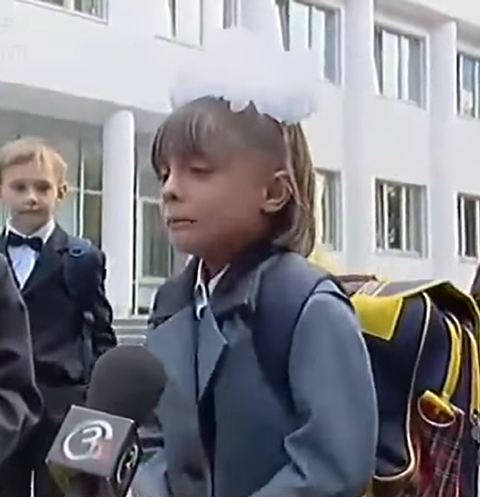
<center>И шарик не дали...</center>

#### Генерация более сложной выборки

Сделаем обучающую выборку на результатах faiss. Векторы будут схожими, научить классификатор разделять их будет сложнее

In [121]:
features = []
target = []
for i, candidates in tqdm(enumerate(idxs_50[:,:10])):
    vec_1 = train_array[i][mask]
    for candidate in candidates:
        vec_2 = base_array[candidate][mask]
        current_distances = get_distances(vec_1,vec_2)
        if targets_train[i] == base_index[candidate]:
            target.append(1)
        else:
            target.append(0)
        features.append(current_distances)

100000it [03:18, 504.86it/s]


In [122]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2, 
                                                    stratify=target, 
                                                    random_state=42)

##### Logreg

In [123]:
model = LogisticRegression(
    max_iter=10000, 
    class_weight='balanced'
)
model.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [124]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.8798482922297228
0.8778318993792027


Логистическая регрессия довольно плохо разделяет близкие векторы по их расстояниям. Проверять ранжирование не будем

##### Catboost

In [125]:
model = CatBoostClassifier(
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_state=42
)

eval_data = Pool(
    data=x_test,
    label=y_test
)

model.fit(x_train,y_train, eval_set=eval_data)

Learning rate set to 0.165186
0:	test: 0.8696512	best: 0.8696512 (0)	total: 65.8ms	remaining: 1m 5s
1:	test: 0.8759731	best: 0.8759731 (1)	total: 134ms	remaining: 1m 6s
2:	test: 0.8772035	best: 0.8772035 (2)	total: 205ms	remaining: 1m 8s
3:	test: 0.8781664	best: 0.8781664 (3)	total: 273ms	remaining: 1m 7s
4:	test: 0.8786182	best: 0.8786182 (4)	total: 336ms	remaining: 1m 6s
5:	test: 0.8813990	best: 0.8813990 (5)	total: 398ms	remaining: 1m 5s
6:	test: 0.8817586	best: 0.8817586 (6)	total: 472ms	remaining: 1m 7s
7:	test: 0.8825384	best: 0.8825384 (7)	total: 533ms	remaining: 1m 6s
8:	test: 0.8828562	best: 0.8828562 (8)	total: 603ms	remaining: 1m 6s
9:	test: 0.8830608	best: 0.8830608 (9)	total: 673ms	remaining: 1m 6s
10:	test: 0.8834406	best: 0.8834406 (10)	total: 736ms	remaining: 1m 6s
11:	test: 0.8836293	best: 0.8836293 (11)	total: 814ms	remaining: 1m 6s
12:	test: 0.8838980	best: 0.8838980 (12)	total: 886ms	remaining: 1m 7s
13:	test: 0.8840454	best: 0.8840454 (13)	total: 951ms	remaining: 1

115:	test: 0.8879483	best: 0.8879540 (112)	total: 8.1s	remaining: 1m 1s
116:	test: 0.8879457	best: 0.8879540 (112)	total: 8.17s	remaining: 1m 1s
117:	test: 0.8879552	best: 0.8879552 (117)	total: 8.24s	remaining: 1m 1s
118:	test: 0.8879523	best: 0.8879552 (117)	total: 8.3s	remaining: 1m 1s
119:	test: 0.8879646	best: 0.8879646 (119)	total: 8.37s	remaining: 1m 1s
120:	test: 0.8879771	best: 0.8879771 (120)	total: 8.44s	remaining: 1m 1s
121:	test: 0.8879877	best: 0.8879877 (121)	total: 8.52s	remaining: 1m 1s
122:	test: 0.8879984	best: 0.8879984 (122)	total: 8.59s	remaining: 1m 1s
123:	test: 0.8879631	best: 0.8879984 (122)	total: 8.67s	remaining: 1m 1s
124:	test: 0.8879933	best: 0.8879984 (122)	total: 8.74s	remaining: 1m 1s
125:	test: 0.8879651	best: 0.8879984 (122)	total: 8.81s	remaining: 1m 1s
126:	test: 0.8879515	best: 0.8879984 (122)	total: 8.88s	remaining: 1m 1s
127:	test: 0.8879385	best: 0.8879984 (122)	total: 8.95s	remaining: 1m 1s
128:	test: 0.8879448	best: 0.8879984 (122)	total: 9.0

231:	test: 0.8876451	best: 0.8879984 (122)	total: 16.3s	remaining: 54s
232:	test: 0.8876384	best: 0.8879984 (122)	total: 16.4s	remaining: 53.9s
233:	test: 0.8876366	best: 0.8879984 (122)	total: 16.5s	remaining: 53.9s
234:	test: 0.8876442	best: 0.8879984 (122)	total: 16.5s	remaining: 53.8s
235:	test: 0.8876259	best: 0.8879984 (122)	total: 16.6s	remaining: 53.7s
236:	test: 0.8876210	best: 0.8879984 (122)	total: 16.7s	remaining: 53.7s
237:	test: 0.8876171	best: 0.8879984 (122)	total: 16.7s	remaining: 53.6s
238:	test: 0.8876202	best: 0.8879984 (122)	total: 16.8s	remaining: 53.5s
239:	test: 0.8875996	best: 0.8879984 (122)	total: 16.9s	remaining: 53.4s
240:	test: 0.8875859	best: 0.8879984 (122)	total: 16.9s	remaining: 53.4s
241:	test: 0.8875900	best: 0.8879984 (122)	total: 17s	remaining: 53.3s
242:	test: 0.8875891	best: 0.8879984 (122)	total: 17.1s	remaining: 53.2s
243:	test: 0.8875797	best: 0.8879984 (122)	total: 17.1s	remaining: 53.1s
244:	test: 0.8875977	best: 0.8879984 (122)	total: 17.2s

344:	test: 0.8869888	best: 0.8879984 (122)	total: 24.2s	remaining: 46s
345:	test: 0.8869864	best: 0.8879984 (122)	total: 24.3s	remaining: 45.9s
346:	test: 0.8869879	best: 0.8879984 (122)	total: 24.4s	remaining: 45.9s
347:	test: 0.8869670	best: 0.8879984 (122)	total: 24.4s	remaining: 45.8s
348:	test: 0.8869682	best: 0.8879984 (122)	total: 24.5s	remaining: 45.7s
349:	test: 0.8869522	best: 0.8879984 (122)	total: 24.6s	remaining: 45.7s
350:	test: 0.8869537	best: 0.8879984 (122)	total: 24.7s	remaining: 45.6s
351:	test: 0.8869626	best: 0.8879984 (122)	total: 24.7s	remaining: 45.5s
352:	test: 0.8869689	best: 0.8879984 (122)	total: 24.8s	remaining: 45.4s
353:	test: 0.8869569	best: 0.8879984 (122)	total: 24.9s	remaining: 45.4s
354:	test: 0.8869380	best: 0.8879984 (122)	total: 24.9s	remaining: 45.3s
355:	test: 0.8868858	best: 0.8879984 (122)	total: 25s	remaining: 45.2s
356:	test: 0.8868884	best: 0.8879984 (122)	total: 25.1s	remaining: 45.2s
357:	test: 0.8868734	best: 0.8879984 (122)	total: 25.1s

457:	test: 0.8867063	best: 0.8879984 (122)	total: 32.2s	remaining: 38.1s
458:	test: 0.8867096	best: 0.8879984 (122)	total: 32.3s	remaining: 38s
459:	test: 0.8867146	best: 0.8879984 (122)	total: 32.3s	remaining: 38s
460:	test: 0.8867119	best: 0.8879984 (122)	total: 32.4s	remaining: 37.9s
461:	test: 0.8867097	best: 0.8879984 (122)	total: 32.5s	remaining: 37.8s
462:	test: 0.8866999	best: 0.8879984 (122)	total: 32.6s	remaining: 37.8s
463:	test: 0.8866954	best: 0.8879984 (122)	total: 32.6s	remaining: 37.7s
464:	test: 0.8866970	best: 0.8879984 (122)	total: 32.7s	remaining: 37.6s
465:	test: 0.8866940	best: 0.8879984 (122)	total: 32.8s	remaining: 37.5s
466:	test: 0.8866941	best: 0.8879984 (122)	total: 32.8s	remaining: 37.5s
467:	test: 0.8866995	best: 0.8879984 (122)	total: 32.9s	remaining: 37.4s
468:	test: 0.8867044	best: 0.8879984 (122)	total: 33s	remaining: 37.3s
469:	test: 0.8866377	best: 0.8879984 (122)	total: 33s	remaining: 37.3s
470:	test: 0.8866315	best: 0.8879984 (122)	total: 33.1s	rem

572:	test: 0.8863351	best: 0.8879984 (122)	total: 40.4s	remaining: 30.1s
573:	test: 0.8863322	best: 0.8879984 (122)	total: 40.5s	remaining: 30.1s
574:	test: 0.8863189	best: 0.8879984 (122)	total: 40.6s	remaining: 30s
575:	test: 0.8863239	best: 0.8879984 (122)	total: 40.7s	remaining: 29.9s
576:	test: 0.8863204	best: 0.8879984 (122)	total: 40.7s	remaining: 29.9s
577:	test: 0.8863256	best: 0.8879984 (122)	total: 40.8s	remaining: 29.8s
578:	test: 0.8863237	best: 0.8879984 (122)	total: 40.9s	remaining: 29.7s
579:	test: 0.8863261	best: 0.8879984 (122)	total: 40.9s	remaining: 29.6s
580:	test: 0.8863213	best: 0.8879984 (122)	total: 41s	remaining: 29.6s
581:	test: 0.8863234	best: 0.8879984 (122)	total: 41.1s	remaining: 29.5s
582:	test: 0.8863292	best: 0.8879984 (122)	total: 41.1s	remaining: 29.4s
583:	test: 0.8863273	best: 0.8879984 (122)	total: 41.2s	remaining: 29.4s
584:	test: 0.8863263	best: 0.8879984 (122)	total: 41.3s	remaining: 29.3s
585:	test: 0.8863243	best: 0.8879984 (122)	total: 41.3s

688:	test: 0.8858390	best: 0.8879984 (122)	total: 48.7s	remaining: 22s
689:	test: 0.8858329	best: 0.8879984 (122)	total: 48.8s	remaining: 21.9s
690:	test: 0.8858287	best: 0.8879984 (122)	total: 48.8s	remaining: 21.8s
691:	test: 0.8858283	best: 0.8879984 (122)	total: 48.9s	remaining: 21.8s
692:	test: 0.8858299	best: 0.8879984 (122)	total: 49s	remaining: 21.7s
693:	test: 0.8858282	best: 0.8879984 (122)	total: 49s	remaining: 21.6s
694:	test: 0.8858182	best: 0.8879984 (122)	total: 49.1s	remaining: 21.6s
695:	test: 0.8858157	best: 0.8879984 (122)	total: 49.2s	remaining: 21.5s
696:	test: 0.8858096	best: 0.8879984 (122)	total: 49.3s	remaining: 21.4s
697:	test: 0.8858172	best: 0.8879984 (122)	total: 49.3s	remaining: 21.3s
698:	test: 0.8857269	best: 0.8879984 (122)	total: 49.4s	remaining: 21.3s
699:	test: 0.8857365	best: 0.8879984 (122)	total: 49.5s	remaining: 21.2s
700:	test: 0.8857401	best: 0.8879984 (122)	total: 49.5s	remaining: 21.1s
701:	test: 0.8857304	best: 0.8879984 (122)	total: 49.6s	r

803:	test: 0.8853477	best: 0.8879984 (122)	total: 56.8s	remaining: 13.9s
804:	test: 0.8853559	best: 0.8879984 (122)	total: 56.9s	remaining: 13.8s
805:	test: 0.8853433	best: 0.8879984 (122)	total: 57s	remaining: 13.7s
806:	test: 0.8853414	best: 0.8879984 (122)	total: 57.1s	remaining: 13.6s
807:	test: 0.8853450	best: 0.8879984 (122)	total: 57.1s	remaining: 13.6s
808:	test: 0.8853466	best: 0.8879984 (122)	total: 57.2s	remaining: 13.5s
809:	test: 0.8853563	best: 0.8879984 (122)	total: 57.3s	remaining: 13.4s
810:	test: 0.8853548	best: 0.8879984 (122)	total: 57.3s	remaining: 13.4s
811:	test: 0.8853365	best: 0.8879984 (122)	total: 57.4s	remaining: 13.3s
812:	test: 0.8853409	best: 0.8879984 (122)	total: 57.5s	remaining: 13.2s
813:	test: 0.8853250	best: 0.8879984 (122)	total: 57.5s	remaining: 13.1s
814:	test: 0.8853282	best: 0.8879984 (122)	total: 57.6s	remaining: 13.1s
815:	test: 0.8853250	best: 0.8879984 (122)	total: 57.7s	remaining: 13s
816:	test: 0.8852998	best: 0.8879984 (122)	total: 57.7s

919:	test: 0.8848457	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.66s
920:	test: 0.8848492	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.59s
921:	test: 0.8848600	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.52s
922:	test: 0.8848264	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.45s
923:	test: 0.8848209	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.38s
924:	test: 0.8848139	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.31s
925:	test: 0.8848168	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.24s
926:	test: 0.8848167	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.17s
927:	test: 0.8848244	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.1s
928:	test: 0.8848213	best: 0.8879984 (122)	total: 1m 5s	remaining: 5.03s
929:	test: 0.8848183	best: 0.8879984 (122)	total: 1m 5s	remaining: 4.96s
930:	test: 0.8847881	best: 0.8879984 (122)	total: 1m 5s	remaining: 4.88s
931:	test: 0.8847885	best: 0.8879984 (122)	total: 1m 5s	remaining: 4.81s
932:	test: 0.8847796	best: 0.8879984 (122)	total: 1m

In [126]:
preds = model.predict(x_test)
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.8879984468178101


Та же история. После 122 итерации алгоритм переобучается. Вероятно, только расстояний недостаточно. Проверим

In [127]:
result = []
for i, candidates in tqdm(enumerate(idxs_50[:,:10])):
    query = train_array[i][mask]
    query_features = make_features(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    
accuracy_n(targets_train, np.array(result))

100000it [03:52, 430.94it/s]


70.529

Ниочем

##### RandomForest

In [128]:
%%time
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               n_jobs=-1)
model.fit(x_train,y_train)

CPU times: total: 23min 50s
Wall time: 4min 14s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [129]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.9967580530391768
0.8777939151078291


Переобучились

<center>Вместо 1000 слов</center>

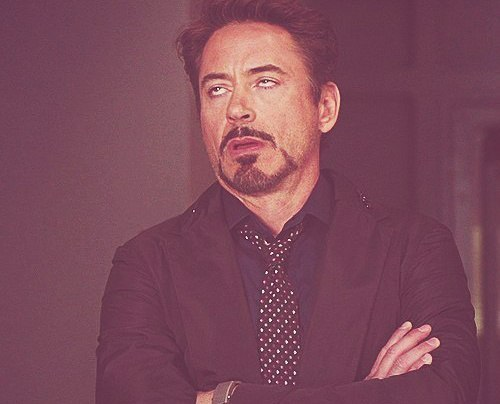

Возможно, стоит добавить деревьев или уменьшить их максимальную глубину, подюирая гиперпараметры с кроссвалидацией. 

Но учитывая долгое время работы алгоритма, есть смысл оставить эксперименты с ним на потом, если не найдем ничего эффективнее.

#### Подход с конкатенацией

Попробуем другой подход. Будем не считать расстояния, а просто конкатенировать векторы друг с другом.

При этом чтобы не терять необходимые мэтчи добавим проверку на нахождения ответа в выдаче, если правильного ответа нет, то добавим

In [131]:
features = []
target = []

for i, candidates in tqdm(enumerate(idxs_50[:,:10])):
    vec_1 = train_array[i] #без маски, т.к. признаки из нее могут разделять векторы
    features.append(make_concatenated(candidates, vec_1, base_array))
    for candidate in candidates:
        if targets_train[i] == base_index[candidate]:
            target.append(1)
        else:
            target.append(0)
    if targets_train[i] not in [base_index[el] for el in candidates]: #добавляем сэмпл с единичкой, если его нет в кандидатах
        features.append(np.hstack([vec_1, base_array[base_index_inverted[targets_train[i]]]]))
        target.append(1)

features = np.vstack(features)
target = np.array(target)

100000it [00:09, 10718.11it/s]


Проверка

In [132]:
print(features.shape)
print(100_000 - accuracy_n(targets_train, idxs_50[:,:10])*1_000)
print(sum(target))

(1026871, 144)
26871.0
100000


In [133]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.2)

In [134]:
# classes = np.unique(y_train)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weights = dict(zip(classes, weights))

##### LogisticRegression

In [135]:
model = LogisticRegression(
    max_iter=10000, 
    class_weight='balanced'
)
model.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [136]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.596000593377289
0.5935024425328661


Даже проверять не стоит

##### CatBoostClassifier

In [150]:
model = CatBoostClassifier(
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_state=42
)

eval_data = Pool(
    data=x_test,
    label=y_test
)

model.fit(x_train,y_train, eval_set=eval_data)

Learning rate set to 0.166271
0:	test: 0.6949143	best: 0.6949143 (0)	total: 159ms	remaining: 2m 38s
1:	test: 0.7177276	best: 0.7177276 (1)	total: 321ms	remaining: 2m 40s
2:	test: 0.7371713	best: 0.7371713 (2)	total: 502ms	remaining: 2m 46s
3:	test: 0.7386232	best: 0.7386232 (3)	total: 680ms	remaining: 2m 49s
4:	test: 0.7433384	best: 0.7433384 (4)	total: 839ms	remaining: 2m 46s
5:	test: 0.7432953	best: 0.7433384 (4)	total: 1.02s	remaining: 2m 49s
6:	test: 0.7592376	best: 0.7592376 (6)	total: 1.17s	remaining: 2m 46s
7:	test: 0.7603653	best: 0.7603653 (7)	total: 1.34s	remaining: 2m 46s
8:	test: 0.7617309	best: 0.7617309 (8)	total: 1.5s	remaining: 2m 44s
9:	test: 0.7648405	best: 0.7648405 (9)	total: 1.65s	remaining: 2m 43s
10:	test: 0.7650998	best: 0.7650998 (10)	total: 1.81s	remaining: 2m 42s
11:	test: 0.7692283	best: 0.7692283 (11)	total: 1.96s	remaining: 2m 41s
12:	test: 0.7713086	best: 0.7713086 (12)	total: 2.11s	remaining: 2m 40s
13:	test: 0.7724253	best: 0.7724253 (13)	total: 2.27s	r

115:	test: 0.8815634	best: 0.8815634 (115)	total: 19.4s	remaining: 2m 27s
116:	test: 0.8819149	best: 0.8819149 (116)	total: 19.6s	remaining: 2m 27s
117:	test: 0.8822962	best: 0.8822962 (117)	total: 19.7s	remaining: 2m 27s
118:	test: 0.8829249	best: 0.8829249 (118)	total: 19.9s	remaining: 2m 27s
119:	test: 0.8834390	best: 0.8834390 (119)	total: 20.1s	remaining: 2m 27s
120:	test: 0.8836705	best: 0.8836705 (120)	total: 20.2s	remaining: 2m 26s
121:	test: 0.8841949	best: 0.8841949 (121)	total: 20.4s	remaining: 2m 26s
122:	test: 0.8846124	best: 0.8846124 (122)	total: 20.6s	remaining: 2m 26s
123:	test: 0.8848763	best: 0.8848763 (123)	total: 20.8s	remaining: 2m 26s
124:	test: 0.8853740	best: 0.8853740 (124)	total: 20.9s	remaining: 2m 26s
125:	test: 0.8856209	best: 0.8856209 (125)	total: 21.1s	remaining: 2m 26s
126:	test: 0.8857496	best: 0.8857496 (126)	total: 21.2s	remaining: 2m 25s
127:	test: 0.8859634	best: 0.8859634 (127)	total: 21.4s	remaining: 2m 25s
128:	test: 0.8863878	best: 0.8863878 (

227:	test: 0.9126997	best: 0.9126997 (227)	total: 37.9s	remaining: 2m 8s
228:	test: 0.9128533	best: 0.9128533 (228)	total: 38.1s	remaining: 2m 8s
229:	test: 0.9131346	best: 0.9131346 (229)	total: 38.2s	remaining: 2m 8s
230:	test: 0.9133197	best: 0.9133197 (230)	total: 38.4s	remaining: 2m 7s
231:	test: 0.9136699	best: 0.9136699 (231)	total: 38.6s	remaining: 2m 7s
232:	test: 0.9137580	best: 0.9137580 (232)	total: 38.7s	remaining: 2m 7s
233:	test: 0.9138599	best: 0.9138599 (233)	total: 38.9s	remaining: 2m 7s
234:	test: 0.9139977	best: 0.9139977 (234)	total: 39.1s	remaining: 2m 7s
235:	test: 0.9140794	best: 0.9140794 (235)	total: 39.2s	remaining: 2m 6s
236:	test: 0.9141817	best: 0.9141817 (236)	total: 39.4s	remaining: 2m 6s
237:	test: 0.9143229	best: 0.9143229 (237)	total: 39.5s	remaining: 2m 6s
238:	test: 0.9144435	best: 0.9144435 (238)	total: 39.7s	remaining: 2m 6s
239:	test: 0.9144809	best: 0.9144809 (239)	total: 39.9s	remaining: 2m 6s
240:	test: 0.9145827	best: 0.9145827 (240)	total: 4

339:	test: 0.9283400	best: 0.9283400 (339)	total: 56.5s	remaining: 1m 49s
340:	test: 0.9283943	best: 0.9283943 (340)	total: 56.6s	remaining: 1m 49s
341:	test: 0.9284514	best: 0.9284514 (341)	total: 56.8s	remaining: 1m 49s
342:	test: 0.9299091	best: 0.9299091 (342)	total: 57s	remaining: 1m 49s
343:	test: 0.9299485	best: 0.9299485 (343)	total: 57.2s	remaining: 1m 49s
344:	test: 0.9306333	best: 0.9306333 (344)	total: 57.4s	remaining: 1m 49s
345:	test: 0.9307263	best: 0.9307263 (345)	total: 57.6s	remaining: 1m 48s
346:	test: 0.9307624	best: 0.9307624 (346)	total: 57.7s	remaining: 1m 48s
347:	test: 0.9308137	best: 0.9308137 (347)	total: 57.9s	remaining: 1m 48s
348:	test: 0.9308425	best: 0.9308425 (348)	total: 58.1s	remaining: 1m 48s
349:	test: 0.9308650	best: 0.9308650 (349)	total: 58.2s	remaining: 1m 48s
350:	test: 0.9309380	best: 0.9309380 (350)	total: 58.4s	remaining: 1m 47s
351:	test: 0.9309824	best: 0.9309824 (351)	total: 58.6s	remaining: 1m 47s
352:	test: 0.9310141	best: 0.9310141 (35

451:	test: 0.9440079	best: 0.9440079 (451)	total: 1m 15s	remaining: 1m 30s
452:	test: 0.9440817	best: 0.9440817 (452)	total: 1m 15s	remaining: 1m 30s
453:	test: 0.9441076	best: 0.9441076 (453)	total: 1m 15s	remaining: 1m 30s
454:	test: 0.9441324	best: 0.9441324 (454)	total: 1m 15s	remaining: 1m 30s
455:	test: 0.9441455	best: 0.9441455 (455)	total: 1m 15s	remaining: 1m 30s
456:	test: 0.9441521	best: 0.9441521 (456)	total: 1m 15s	remaining: 1m 30s
457:	test: 0.9442937	best: 0.9442937 (457)	total: 1m 15s	remaining: 1m 29s
458:	test: 0.9443252	best: 0.9443252 (458)	total: 1m 16s	remaining: 1m 29s
459:	test: 0.9443536	best: 0.9443536 (459)	total: 1m 16s	remaining: 1m 29s
460:	test: 0.9443857	best: 0.9443857 (460)	total: 1m 16s	remaining: 1m 29s
461:	test: 0.9444021	best: 0.9444021 (461)	total: 1m 16s	remaining: 1m 29s
462:	test: 0.9444018	best: 0.9444021 (461)	total: 1m 16s	remaining: 1m 29s
463:	test: 0.9447699	best: 0.9447699 (463)	total: 1m 16s	remaining: 1m 28s
464:	test: 0.9447859	best

562:	test: 0.9482794	best: 0.9482794 (562)	total: 1m 32s	remaining: 1m 12s
563:	test: 0.9483374	best: 0.9483374 (563)	total: 1m 33s	remaining: 1m 12s
564:	test: 0.9483504	best: 0.9483504 (564)	total: 1m 33s	remaining: 1m 11s
565:	test: 0.9483465	best: 0.9483504 (564)	total: 1m 33s	remaining: 1m 11s
566:	test: 0.9484442	best: 0.9484442 (566)	total: 1m 33s	remaining: 1m 11s
567:	test: 0.9484630	best: 0.9484630 (567)	total: 1m 33s	remaining: 1m 11s
568:	test: 0.9484655	best: 0.9484655 (568)	total: 1m 33s	remaining: 1m 11s
569:	test: 0.9484849	best: 0.9484849 (569)	total: 1m 34s	remaining: 1m 10s
570:	test: 0.9484982	best: 0.9484982 (570)	total: 1m 34s	remaining: 1m 10s
571:	test: 0.9485251	best: 0.9485251 (571)	total: 1m 34s	remaining: 1m 10s
572:	test: 0.9485463	best: 0.9485463 (572)	total: 1m 34s	remaining: 1m 10s
573:	test: 0.9485679	best: 0.9485679 (573)	total: 1m 34s	remaining: 1m 10s
574:	test: 0.9485867	best: 0.9485867 (574)	total: 1m 34s	remaining: 1m 10s
575:	test: 0.9485983	best

674:	test: 0.9515536	best: 0.9515536 (674)	total: 1m 50s	remaining: 53.4s
675:	test: 0.9517447	best: 0.9517447 (675)	total: 1m 51s	remaining: 53.2s
676:	test: 0.9517912	best: 0.9517912 (676)	total: 1m 51s	remaining: 53.1s
677:	test: 0.9517968	best: 0.9517968 (677)	total: 1m 51s	remaining: 52.9s
678:	test: 0.9517955	best: 0.9517968 (677)	total: 1m 51s	remaining: 52.7s
679:	test: 0.9518058	best: 0.9518058 (679)	total: 1m 51s	remaining: 52.5s
680:	test: 0.9518085	best: 0.9518085 (680)	total: 1m 51s	remaining: 52.4s
681:	test: 0.9518443	best: 0.9518443 (681)	total: 1m 51s	remaining: 52.2s
682:	test: 0.9518569	best: 0.9518569 (682)	total: 1m 52s	remaining: 52s
683:	test: 0.9518497	best: 0.9518569 (682)	total: 1m 52s	remaining: 51.9s
684:	test: 0.9518621	best: 0.9518621 (684)	total: 1m 52s	remaining: 51.7s
685:	test: 0.9519403	best: 0.9519403 (685)	total: 1m 52s	remaining: 51.5s
686:	test: 0.9519466	best: 0.9519466 (686)	total: 1m 52s	remaining: 51.4s
687:	test: 0.9519579	best: 0.9519579 (68

786:	test: 0.9543417	best: 0.9543417 (786)	total: 2m 8s	remaining: 34.8s
787:	test: 0.9543564	best: 0.9543564 (787)	total: 2m 8s	remaining: 34.6s
788:	test: 0.9543628	best: 0.9543628 (788)	total: 2m 8s	remaining: 34.4s
789:	test: 0.9543759	best: 0.9543759 (789)	total: 2m 8s	remaining: 34.3s
790:	test: 0.9543928	best: 0.9543928 (790)	total: 2m 9s	remaining: 34.1s
791:	test: 0.9544014	best: 0.9544014 (791)	total: 2m 9s	remaining: 33.9s
792:	test: 0.9544005	best: 0.9544014 (791)	total: 2m 9s	remaining: 33.7s
793:	test: 0.9544041	best: 0.9544041 (793)	total: 2m 9s	remaining: 33.6s
794:	test: 0.9544128	best: 0.9544128 (794)	total: 2m 9s	remaining: 33.4s
795:	test: 0.9544068	best: 0.9544128 (794)	total: 2m 9s	remaining: 33.2s
796:	test: 0.9544155	best: 0.9544155 (796)	total: 2m 9s	remaining: 33.1s
797:	test: 0.9547089	best: 0.9547089 (797)	total: 2m 10s	remaining: 32.9s
798:	test: 0.9549787	best: 0.9549787 (798)	total: 2m 10s	remaining: 32.8s
799:	test: 0.9555504	best: 0.9555504 (799)	total:

898:	test: 0.9636475	best: 0.9636514 (896)	total: 2m 26s	remaining: 16.4s
899:	test: 0.9636612	best: 0.9636612 (899)	total: 2m 26s	remaining: 16.3s
900:	test: 0.9636600	best: 0.9636612 (899)	total: 2m 26s	remaining: 16.1s
901:	test: 0.9636643	best: 0.9636643 (901)	total: 2m 26s	remaining: 15.9s
902:	test: 0.9636742	best: 0.9636742 (902)	total: 2m 26s	remaining: 15.8s
903:	test: 0.9636771	best: 0.9636771 (903)	total: 2m 26s	remaining: 15.6s
904:	test: 0.9636762	best: 0.9636771 (903)	total: 2m 27s	remaining: 15.4s
905:	test: 0.9636790	best: 0.9636790 (905)	total: 2m 27s	remaining: 15.3s
906:	test: 0.9636809	best: 0.9636809 (906)	total: 2m 27s	remaining: 15.1s
907:	test: 0.9636845	best: 0.9636845 (907)	total: 2m 27s	remaining: 14.9s
908:	test: 0.9636811	best: 0.9636845 (907)	total: 2m 27s	remaining: 14.8s
909:	test: 0.9636884	best: 0.9636884 (909)	total: 2m 27s	remaining: 14.6s
910:	test: 0.9636833	best: 0.9636884 (909)	total: 2m 27s	remaining: 14.5s
911:	test: 0.9636986	best: 0.9636986 (

In [151]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.9769872173887232
0.9645586102117162


Уже хорошо. Алгоритм пока топ-1. Даже можно добавить доп. деревьев, т.к. нет переобучения

In [152]:
result = []
for i, candidates in tqdm(enumerate(idxs_50[:,:10])):
    query = train_array[i]
    query_features = make_concatenated(candidates, query, base_array)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_train, np.array(result))

100000it [01:48, 920.70it/s]


72.411

Вывод:

Есть профит - хороший результат на трейне. Cтоит поэкспериментировать позднее

##### RandomForestClassifier

In [153]:
%%time
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               n_jobs=-1)
model.fit(x_train,y_train)

CPU times: total: 1h 53min 41s
Wall time: 20min 37s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [156]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

1.0
0.8008858187047431


Переобучение. Нужно контроллиовать глубину деревьев

<center>Пора покормить кота, а то он долго ждал пока исследователь экспериментировал. Извините, мистер кот, уже бегу</center>

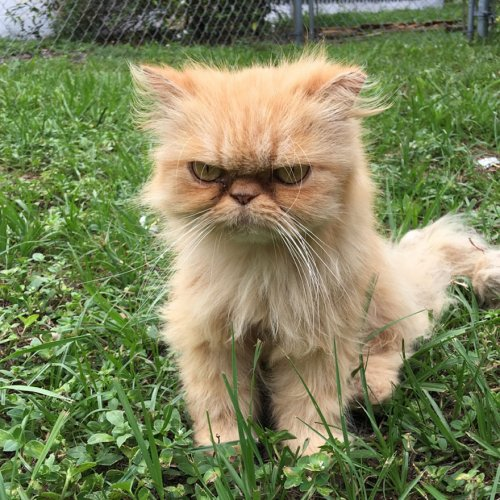

#### <a id="title1">Конкатенация и расстояния</a> 

Следующей итерацией попробуем добавить расстояния к конкатенированным векторам, то есть совместить 2 подхода.

При этом, для подсчета расстояний будем использовать маску, чтобы исключить влияние странных признаков

In [158]:
features = []
target = []

for i, candidates in tqdm(enumerate(idxs_50[:,:10])):
    vec_1 = train_array[i]
    features.append(make_concatenated_with_distances(candidates, vec_1, base_array))
    for candidate in candidates:
        if targets_train[i] == base_index[candidate]:
            target.append(1)
        else:
            target.append(0)
    if targets_train[i] not in [base_index[el] for el in candidates]:
        concatenated_vec = np.hstack([vec_1, base_array[base_index_inverted[targets_train[i]]]])
        distances = get_distances(concatenated_vec[:72][mask],concatenated_vec[72:][mask]) #для дистанций удаляем признаки
        concatenated_with_distances = np.hstack([concatenated_vec,distances])
        features.append(concatenated_with_distances)
        target.append(1)

features = np.vstack(features)
target = np.array(target)

100000it [03:27, 482.30it/s]


In [ ]:
# np.save('datasets/features_50_with_dropped.npy', features)
# np.save('datasets/target_50_with_dropped.npy', target)

In [ ]:
features = np.load('datasets/features_50_with_dropped.npy')
target = np.load('datasets/target_50_with_dropped.npy')

In [159]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2, 
                                                    random_state=42)

##### Logreg

In [160]:
%%time
model = LogisticRegression(
    max_iter=10000, 
    class_weight='balanced'
)
model.fit(x_train,y_train)

CPU times: total: 11min 46s
Wall time: 2min 10s


LogisticRegression(class_weight='balanced', max_iter=10000)

In [161]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.8065186990438887
0.8011648449680635


##### CatBoostClassifier

In [162]:
model = CatBoostClassifier(
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_state=42
)

eval_data = Pool(
    data=x_test,
    label=y_test
)

model.fit(x_train,y_train, eval_set=eval_data)

Learning rate set to 0.166271
0:	test: 0.8144862	best: 0.8144862 (0)	total: 155ms	remaining: 2m 34s
1:	test: 0.8550094	best: 0.8550094 (1)	total: 341ms	remaining: 2m 50s
2:	test: 0.8567149	best: 0.8567149 (2)	total: 510ms	remaining: 2m 49s
3:	test: 0.8620004	best: 0.8620004 (3)	total: 689ms	remaining: 2m 51s
4:	test: 0.8662713	best: 0.8662713 (4)	total: 858ms	remaining: 2m 50s
5:	test: 0.8739857	best: 0.8739857 (5)	total: 1.04s	remaining: 2m 53s
6:	test: 0.8820721	best: 0.8820721 (6)	total: 1.19s	remaining: 2m 49s
7:	test: 0.8848632	best: 0.8848632 (7)	total: 1.35s	remaining: 2m 46s
8:	test: 0.8885598	best: 0.8885598 (8)	total: 1.49s	remaining: 2m 43s
9:	test: 0.8894767	best: 0.8894767 (9)	total: 1.66s	remaining: 2m 44s
10:	test: 0.8928069	best: 0.8928069 (10)	total: 1.81s	remaining: 2m 42s
11:	test: 0.8942957	best: 0.8942957 (11)	total: 1.98s	remaining: 2m 42s
12:	test: 0.8959222	best: 0.8959222 (12)	total: 2.15s	remaining: 2m 42s
13:	test: 0.8980081	best: 0.8980081 (13)	total: 2.34s	

115:	test: 0.9331155	best: 0.9331155 (115)	total: 20.7s	remaining: 2m 37s
116:	test: 0.9334303	best: 0.9334303 (116)	total: 20.9s	remaining: 2m 37s
117:	test: 0.9335322	best: 0.9335322 (117)	total: 21.1s	remaining: 2m 37s
118:	test: 0.9335787	best: 0.9335787 (118)	total: 21.3s	remaining: 2m 37s
119:	test: 0.9340448	best: 0.9340448 (119)	total: 21.5s	remaining: 2m 37s
120:	test: 0.9343195	best: 0.9343195 (120)	total: 21.7s	remaining: 2m 37s
121:	test: 0.9343690	best: 0.9343690 (121)	total: 21.9s	remaining: 2m 37s
122:	test: 0.9344424	best: 0.9344424 (122)	total: 22.1s	remaining: 2m 37s
123:	test: 0.9344870	best: 0.9344870 (123)	total: 22.2s	remaining: 2m 36s
124:	test: 0.9345156	best: 0.9345156 (124)	total: 22.4s	remaining: 2m 36s
125:	test: 0.9345522	best: 0.9345522 (125)	total: 22.5s	remaining: 2m 36s
126:	test: 0.9346116	best: 0.9346116 (126)	total: 22.7s	remaining: 2m 36s
127:	test: 0.9346657	best: 0.9346657 (127)	total: 22.9s	remaining: 2m 35s
128:	test: 0.9347042	best: 0.9347042 (

227:	test: 0.9416513	best: 0.9416513 (227)	total: 40.5s	remaining: 2m 17s
228:	test: 0.9416777	best: 0.9416777 (228)	total: 40.6s	remaining: 2m 16s
229:	test: 0.9416812	best: 0.9416812 (229)	total: 40.8s	remaining: 2m 16s
230:	test: 0.9416892	best: 0.9416892 (230)	total: 41s	remaining: 2m 16s
231:	test: 0.9416833	best: 0.9416892 (230)	total: 41.1s	remaining: 2m 16s
232:	test: 0.9416751	best: 0.9416892 (230)	total: 41.3s	remaining: 2m 15s
233:	test: 0.9417492	best: 0.9417492 (233)	total: 41.5s	remaining: 2m 15s
234:	test: 0.9417872	best: 0.9417872 (234)	total: 41.6s	remaining: 2m 15s
235:	test: 0.9418006	best: 0.9418006 (235)	total: 41.8s	remaining: 2m 15s
236:	test: 0.9421401	best: 0.9421401 (236)	total: 42s	remaining: 2m 15s
237:	test: 0.9423289	best: 0.9423289 (237)	total: 42.2s	remaining: 2m 15s
238:	test: 0.9423864	best: 0.9423864 (238)	total: 42.4s	remaining: 2m 14s
239:	test: 0.9423870	best: 0.9423870 (239)	total: 42.6s	remaining: 2m 14s
240:	test: 0.9424005	best: 0.9424005 (240)

339:	test: 0.9486803	best: 0.9486803 (339)	total: 59.8s	remaining: 1m 56s
340:	test: 0.9486846	best: 0.9486846 (340)	total: 1m	remaining: 1m 55s
341:	test: 0.9486769	best: 0.9486846 (340)	total: 1m	remaining: 1m 55s
342:	test: 0.9486853	best: 0.9486853 (342)	total: 1m	remaining: 1m 55s
343:	test: 0.9486966	best: 0.9486966 (343)	total: 1m	remaining: 1m 55s
344:	test: 0.9487380	best: 0.9487380 (344)	total: 1m	remaining: 1m 55s
345:	test: 0.9487410	best: 0.9487410 (345)	total: 1m	remaining: 1m 55s
346:	test: 0.9487266	best: 0.9487410 (345)	total: 1m 1s	remaining: 1m 54s
347:	test: 0.9487463	best: 0.9487463 (347)	total: 1m 1s	remaining: 1m 54s
348:	test: 0.9487503	best: 0.9487503 (348)	total: 1m 1s	remaining: 1m 54s
349:	test: 0.9487650	best: 0.9487650 (349)	total: 1m 1s	remaining: 1m 54s
350:	test: 0.9487714	best: 0.9487714 (350)	total: 1m 1s	remaining: 1m 54s
351:	test: 0.9488457	best: 0.9488457 (351)	total: 1m 1s	remaining: 1m 53s
352:	test: 0.9488389	best: 0.9488457 (351)	total: 1m 2s	

451:	test: 0.9555214	best: 0.9555214 (451)	total: 1m 18s	remaining: 1m 34s
452:	test: 0.9555505	best: 0.9555505 (452)	total: 1m 18s	remaining: 1m 34s
453:	test: 0.9555994	best: 0.9555994 (453)	total: 1m 18s	remaining: 1m 34s
454:	test: 0.9556404	best: 0.9556404 (454)	total: 1m 18s	remaining: 1m 34s
455:	test: 0.9556511	best: 0.9556511 (455)	total: 1m 19s	remaining: 1m 34s
456:	test: 0.9556446	best: 0.9556511 (455)	total: 1m 19s	remaining: 1m 34s
457:	test: 0.9556483	best: 0.9556511 (455)	total: 1m 19s	remaining: 1m 33s
458:	test: 0.9556575	best: 0.9556575 (458)	total: 1m 19s	remaining: 1m 33s
459:	test: 0.9556544	best: 0.9556575 (458)	total: 1m 19s	remaining: 1m 33s
460:	test: 0.9556662	best: 0.9556662 (460)	total: 1m 19s	remaining: 1m 33s
461:	test: 0.9556804	best: 0.9556804 (461)	total: 1m 20s	remaining: 1m 33s
462:	test: 0.9557068	best: 0.9557068 (462)	total: 1m 20s	remaining: 1m 33s
463:	test: 0.9556994	best: 0.9557068 (462)	total: 1m 20s	remaining: 1m 33s
464:	test: 0.9557040	best

561:	test: 0.9596604	best: 0.9596604 (561)	total: 1m 40s	remaining: 1m 18s
562:	test: 0.9596602	best: 0.9596604 (561)	total: 1m 40s	remaining: 1m 18s
563:	test: 0.9596612	best: 0.9596612 (563)	total: 1m 41s	remaining: 1m 18s
564:	test: 0.9596517	best: 0.9596612 (563)	total: 1m 41s	remaining: 1m 17s
565:	test: 0.9596584	best: 0.9596612 (563)	total: 1m 41s	remaining: 1m 17s
566:	test: 0.9596759	best: 0.9596759 (566)	total: 1m 41s	remaining: 1m 17s
567:	test: 0.9600531	best: 0.9600531 (567)	total: 1m 41s	remaining: 1m 17s
568:	test: 0.9601441	best: 0.9601441 (568)	total: 1m 42s	remaining: 1m 17s
569:	test: 0.9601482	best: 0.9601482 (569)	total: 1m 42s	remaining: 1m 17s
570:	test: 0.9601441	best: 0.9601482 (569)	total: 1m 42s	remaining: 1m 16s
571:	test: 0.9601392	best: 0.9601482 (569)	total: 1m 42s	remaining: 1m 16s
572:	test: 0.9601645	best: 0.9601645 (572)	total: 1m 42s	remaining: 1m 16s
573:	test: 0.9601703	best: 0.9601703 (573)	total: 1m 42s	remaining: 1m 16s
574:	test: 0.9601708	best

673:	test: 0.9661059	best: 0.9661095 (672)	total: 2m	remaining: 58.4s
674:	test: 0.9661016	best: 0.9661095 (672)	total: 2m 1s	remaining: 58.3s
675:	test: 0.9661140	best: 0.9661140 (675)	total: 2m 1s	remaining: 58.1s
676:	test: 0.9661271	best: 0.9661271 (676)	total: 2m 1s	remaining: 57.9s
677:	test: 0.9661264	best: 0.9661271 (676)	total: 2m 1s	remaining: 57.7s
678:	test: 0.9661326	best: 0.9661326 (678)	total: 2m 1s	remaining: 57.6s
679:	test: 0.9661327	best: 0.9661327 (679)	total: 2m 1s	remaining: 57.4s
680:	test: 0.9661234	best: 0.9661327 (679)	total: 2m 2s	remaining: 57.2s
681:	test: 0.9661306	best: 0.9661327 (679)	total: 2m 2s	remaining: 57s
682:	test: 0.9661140	best: 0.9661327 (679)	total: 2m 2s	remaining: 56.9s
683:	test: 0.9661220	best: 0.9661327 (679)	total: 2m 2s	remaining: 56.7s
684:	test: 0.9661300	best: 0.9661327 (679)	total: 2m 2s	remaining: 56.5s
685:	test: 0.9661296	best: 0.9661327 (679)	total: 2m 3s	remaining: 56.3s
686:	test: 0.9661406	best: 0.9661406 (686)	total: 2m 3s	

785:	test: 0.9694777	best: 0.9694777 (785)	total: 2m 20s	remaining: 38.2s
786:	test: 0.9694760	best: 0.9694777 (785)	total: 2m 20s	remaining: 38s
787:	test: 0.9694807	best: 0.9694807 (787)	total: 2m 20s	remaining: 37.9s
788:	test: 0.9694807	best: 0.9694807 (787)	total: 2m 20s	remaining: 37.7s
789:	test: 0.9694847	best: 0.9694847 (789)	total: 2m 21s	remaining: 37.5s
790:	test: 0.9694845	best: 0.9694847 (789)	total: 2m 21s	remaining: 37.3s
791:	test: 0.9694905	best: 0.9694905 (791)	total: 2m 21s	remaining: 37.1s
792:	test: 0.9694923	best: 0.9694923 (792)	total: 2m 21s	remaining: 37s
793:	test: 0.9694858	best: 0.9694923 (792)	total: 2m 21s	remaining: 36.8s
794:	test: 0.9694921	best: 0.9694923 (792)	total: 2m 22s	remaining: 36.6s
795:	test: 0.9694917	best: 0.9694923 (792)	total: 2m 22s	remaining: 36.4s
796:	test: 0.9694907	best: 0.9694923 (792)	total: 2m 22s	remaining: 36.3s
797:	test: 0.9694923	best: 0.9694923 (792)	total: 2m 22s	remaining: 36.1s
798:	test: 0.9694898	best: 0.9694923 (792)

896:	test: 0.9702722	best: 0.9702722 (896)	total: 2m 39s	remaining: 18.3s
897:	test: 0.9704376	best: 0.9704376 (897)	total: 2m 39s	remaining: 18.2s
898:	test: 0.9704708	best: 0.9704708 (898)	total: 2m 40s	remaining: 18s
899:	test: 0.9704796	best: 0.9704796 (899)	total: 2m 40s	remaining: 17.8s
900:	test: 0.9704885	best: 0.9704885 (900)	total: 2m 40s	remaining: 17.6s
901:	test: 0.9704956	best: 0.9704956 (901)	total: 2m 40s	remaining: 17.5s
902:	test: 0.9705241	best: 0.9705241 (902)	total: 2m 40s	remaining: 17.3s
903:	test: 0.9706887	best: 0.9706887 (903)	total: 2m 40s	remaining: 17.1s
904:	test: 0.9706835	best: 0.9706887 (903)	total: 2m 41s	remaining: 16.9s
905:	test: 0.9706767	best: 0.9706887 (903)	total: 2m 41s	remaining: 16.7s
906:	test: 0.9706891	best: 0.9706891 (906)	total: 2m 41s	remaining: 16.6s
907:	test: 0.9706904	best: 0.9706904 (907)	total: 2m 41s	remaining: 16.4s
908:	test: 0.9706880	best: 0.9706904 (907)	total: 2m 41s	remaining: 16.2s
909:	test: 0.9706946	best: 0.9706946 (90

In [163]:
preds = model.predict(x_test)
print(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

0.9855803128476791
0.9720834872063481


In [164]:
result = []
for i, candidates in tqdm(enumerate(idxs_50[:,:10])):
    query = train_array[i]
    query_features = make_concatenated_with_distances(candidates, query, base_array)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_train, np.array(result))

100000it [05:19, 312.52it/s]


72.75

Это лучшая модель на данный момент. Векторы вместе с расстояниями разделяют классы лучше. Можно попробовать RF, но инференс очень долгий, остановимся на катбусте.

Посмотрим результат тестовой выборки

In [166]:
%%time
result = []
for i, candidates in tqdm(enumerate(idxs_val_50[:,:10])):
    query = validation_array[i]
    query_features = make_concatenated_with_distances(candidates, query, base_array)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_val, np.array(result))

100000it [05:17, 315.28it/s]


CPU times: total: 6min 13s
Wall time: 5min 17s


72.077

И на 50 векторах

In [176]:
%%time
result = []
for i, candidates in tqdm(enumerate(idxs_val_50)):
    query = validation_array[i]
    query_features = make_concatenated_with_distances(candidates, query, base_array)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_val, np.array(result))

100000it [21:24, 77.88it/s]


CPU times: total: 22min 20s
Wall time: 21min 34s


71.107

50 векторов ранжируются уже хуже

#### Улучшение результата

Что дальше:
- Прежде всего, улучшим результат Faiss: сделаем поиск на большем числе соседей и на большем числе кластеров - получим больше фич.
- Проведем тюнинг модели по сетке

In [29]:
index = faiss.index_factory(dims,'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.add(np.ascontiguousarray(base_array[:,mask]).astype('float32'))
index.nprobe = 256

In [183]:
del idxs_50
del x_train
del y_train
del x_test
del y_test
del result

In [30]:
%%time
_, idxs_50 = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 50)
accuracy_n(targets_train, idxs_50)

CPU times: total: 50min 56s
Wall time: 9min 33s


78.645

In [31]:
%%time
_, idxs_val_50 = index.search(np.ascontiguousarray(validation_array[:,mask]).astype('float32'), 50)
accuracy_n(targets_val, idxs_val_50)

CPU times: total: 51min 19s
Wall time: 9min 26s


78.538

In [35]:
np.save('datasets/idxs_50.npy', idxs_50)
np.save('datasets/idxs_val_50.npy', idxs_val_50)

In [36]:
del _
del idxs_val_50
del idxs_50

In [ ]:
idxs_50 = np.load('datasets/idxs_50.npy')

In [32]:
features = []
target = []

for i, candidates in tqdm(enumerate(idxs_50)):
    vec_1 = train_array[i]
    features.append(make_concatenated_with_distances(candidates, vec_1, base_array))
    for candidate in candidates:
        if targets_train[i] == base_index[candidate]:
            target.append(1)
        else:
            target.append(0)
    if targets_train[i] not in [base_index[el] for el in candidates]:
        concatenated_vec = np.hstack([vec_1, base_array[base_index_inverted[targets_train[i]]]])
        distances = get_distances(concatenated_vec[:72][mask],concatenated_vec[72:][mask]) #для дистанций удаляем признаки
        concatenated_with_distances = np.hstack([concatenated_vec,distances])
        features.append(concatenated_with_distances)
        target.append(1)

features = np.vstack(features)
target = np.array(target)

100000it [16:57, 98.25it/s]


Поиск по сетке по всем этим данным не влезет в память, проверим на 10%

In [38]:
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    train_size=0.1, 
                                                    test_size=0.1, 
                                                    stratify=target,
                                                    random_state=42)

In [34]:
np.save('datasets/features_50.npy', features)
np.save('datasets/target_50.npy', target)

In [39]:
del x_test
del y_test
del features
del target

In [41]:
%%time
model = CatBoostClassifier(
    logging_level='Silent',
    eval_metric='AUC',
    random_state=42
)

PARAMS = {
    'iterations': [1000, 1250, 1500],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [3,5,7]
}
model.grid_search(PARAMS, 
                  x_train, 
                  y_train, 
                  cv=5, 
#                   plot=True,
                  refit=True)

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9174391	best: 0.9174391 (0)	total: 1m 16s	remaining: 32m 59s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9410941	best: 0.9410941 (1)	total: 2m 7s	remaining: 26m 36s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9560074	best: 0.9560074 (2)	total: 2m 59s	remaining: 23m 57s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9198547	best: 0.9560074 (2)	total: 4m 3s	remaining: 23m 21s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.9499611	best: 0.9560074 (2)	total

{'params': {'depth': 7, 'iterations': 1500, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [42]:
del x_train
del y_train

In [43]:
features = np.load('datasets/features_50.npy')
target = np.load('datasets/target_50.npy')

In [44]:
model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.1,
    depth=7,
    eval_metric='AUC',
    random_state=42
)

model.fit(features,target)

0:	total: 1.12s	remaining: 28m 4s
1:	total: 2.26s	remaining: 28m 13s
2:	total: 3.37s	remaining: 27m 59s
3:	total: 4.32s	remaining: 26m 54s
4:	total: 5.28s	remaining: 26m 18s
5:	total: 6.21s	remaining: 25m 47s
6:	total: 7.04s	remaining: 25m 1s
7:	total: 8.04s	remaining: 25m
8:	total: 8.99s	remaining: 24m 49s
9:	total: 9.78s	remaining: 24m 17s
10:	total: 11.1s	remaining: 25m 2s
11:	total: 12s	remaining: 24m 46s
12:	total: 12.8s	remaining: 24m 24s
13:	total: 13.6s	remaining: 24m 8s
14:	total: 14.5s	remaining: 23m 52s
15:	total: 15.7s	remaining: 24m 19s
16:	total: 16.6s	remaining: 24m 11s
17:	total: 17.8s	remaining: 24m 23s
18:	total: 18.6s	remaining: 24m 10s
19:	total: 19.6s	remaining: 24m 10s
20:	total: 20.8s	remaining: 24m 26s
21:	total: 21.7s	remaining: 24m 17s
22:	total: 22.8s	remaining: 24m 24s
23:	total: 24s	remaining: 24m 36s
24:	total: 25.2s	remaining: 24m 48s
25:	total: 26.2s	remaining: 24m 48s
26:	total: 27.1s	remaining: 24m 38s
27:	total: 28.1s	remaining: 24m 35s
28:	total: 29.

223:	total: 3m 58s	remaining: 22m 38s
224:	total: 3m 59s	remaining: 22m 36s
225:	total: 4m	remaining: 22m 35s
226:	total: 4m 1s	remaining: 22m 34s
227:	total: 4m 2s	remaining: 22m 33s
228:	total: 4m 3s	remaining: 22m 31s
229:	total: 4m 4s	remaining: 22m 30s
230:	total: 4m 5s	remaining: 22m 29s
231:	total: 4m 6s	remaining: 22m 28s
232:	total: 4m 7s	remaining: 22m 26s
233:	total: 4m 8s	remaining: 22m 24s
234:	total: 4m 9s	remaining: 22m 23s
235:	total: 4m 10s	remaining: 22m 22s
236:	total: 4m 11s	remaining: 22m 20s
237:	total: 4m 12s	remaining: 22m 18s
238:	total: 4m 13s	remaining: 22m 16s
239:	total: 4m 14s	remaining: 22m 17s
240:	total: 4m 15s	remaining: 22m 16s
241:	total: 4m 17s	remaining: 22m 16s
242:	total: 4m 18s	remaining: 22m 15s
243:	total: 4m 19s	remaining: 22m 14s
244:	total: 4m 20s	remaining: 22m 14s
245:	total: 4m 21s	remaining: 22m 13s
246:	total: 4m 22s	remaining: 22m 13s
247:	total: 4m 23s	remaining: 22m 12s
248:	total: 4m 25s	remaining: 22m 12s
249:	total: 4m 26s	remain

442:	total: 7m 44s	remaining: 18m 28s
443:	total: 7m 45s	remaining: 18m 28s
444:	total: 7m 46s	remaining: 18m 26s
445:	total: 7m 47s	remaining: 18m 25s
446:	total: 7m 49s	remaining: 18m 25s
447:	total: 7m 49s	remaining: 18m 23s
448:	total: 7m 50s	remaining: 18m 22s
449:	total: 7m 52s	remaining: 18m 21s
450:	total: 7m 52s	remaining: 18m 20s
451:	total: 7m 54s	remaining: 18m 19s
452:	total: 7m 55s	remaining: 18m 18s
453:	total: 7m 56s	remaining: 18m 17s
454:	total: 7m 57s	remaining: 18m 16s
455:	total: 7m 58s	remaining: 18m 15s
456:	total: 7m 59s	remaining: 18m 14s
457:	total: 8m	remaining: 18m 13s
458:	total: 8m 1s	remaining: 18m 12s
459:	total: 8m 2s	remaining: 18m 11s
460:	total: 8m 3s	remaining: 18m 9s
461:	total: 8m 4s	remaining: 18m 8s
462:	total: 8m 5s	remaining: 18m 6s
463:	total: 8m 6s	remaining: 18m 5s
464:	total: 8m 7s	remaining: 18m 4s
465:	total: 8m 8s	remaining: 18m 3s
466:	total: 8m 9s	remaining: 18m 2s
467:	total: 8m 10s	remaining: 18m 1s
468:	total: 8m 11s	remaining: 17m

658:	total: 11m 27s	remaining: 14m 37s
659:	total: 11m 28s	remaining: 14m 36s
660:	total: 11m 29s	remaining: 14m 34s
661:	total: 11m 30s	remaining: 14m 33s
662:	total: 11m 31s	remaining: 14m 32s
663:	total: 11m 32s	remaining: 14m 31s
664:	total: 11m 33s	remaining: 14m 30s
665:	total: 11m 34s	remaining: 14m 29s
666:	total: 11m 35s	remaining: 14m 28s
667:	total: 11m 36s	remaining: 14m 27s
668:	total: 11m 37s	remaining: 14m 26s
669:	total: 11m 38s	remaining: 14m 25s
670:	total: 11m 39s	remaining: 14m 24s
671:	total: 11m 40s	remaining: 14m 23s
672:	total: 11m 41s	remaining: 14m 22s
673:	total: 11m 42s	remaining: 14m 21s
674:	total: 11m 44s	remaining: 14m 20s
675:	total: 11m 45s	remaining: 14m 19s
676:	total: 11m 46s	remaining: 14m 18s
677:	total: 11m 47s	remaining: 14m 17s
678:	total: 11m 48s	remaining: 14m 16s
679:	total: 11m 49s	remaining: 14m 15s
680:	total: 11m 50s	remaining: 14m 14s
681:	total: 11m 51s	remaining: 14m 13s
682:	total: 11m 52s	remaining: 14m 12s
683:	total: 11m 54s	remai

871:	total: 14m 57s	remaining: 10m 46s
872:	total: 14m 58s	remaining: 10m 45s
873:	total: 14m 59s	remaining: 10m 44s
874:	total: 15m 1s	remaining: 10m 43s
875:	total: 15m 1s	remaining: 10m 42s
876:	total: 15m 2s	remaining: 10m 41s
877:	total: 15m 3s	remaining: 10m 40s
878:	total: 15m 4s	remaining: 10m 39s
879:	total: 15m 5s	remaining: 10m 37s
880:	total: 15m 6s	remaining: 10m 36s
881:	total: 15m 7s	remaining: 10m 35s
882:	total: 15m 8s	remaining: 10m 34s
883:	total: 15m 9s	remaining: 10m 33s
884:	total: 15m 10s	remaining: 10m 32s
885:	total: 15m 11s	remaining: 10m 31s
886:	total: 15m 12s	remaining: 10m 30s
887:	total: 15m 13s	remaining: 10m 29s
888:	total: 15m 14s	remaining: 10m 28s
889:	total: 15m 15s	remaining: 10m 27s
890:	total: 15m 16s	remaining: 10m 26s
891:	total: 15m 17s	remaining: 10m 25s
892:	total: 15m 18s	remaining: 10m 24s
893:	total: 15m 18s	remaining: 10m 22s
894:	total: 15m 19s	remaining: 10m 21s
895:	total: 15m 20s	remaining: 10m 20s
896:	total: 15m 21s	remaining: 10m 

1086:	total: 18m 34s	remaining: 7m 3s
1087:	total: 18m 35s	remaining: 7m 2s
1088:	total: 18m 36s	remaining: 7m 1s
1089:	total: 18m 37s	remaining: 7m
1090:	total: 18m 38s	remaining: 6m 59s
1091:	total: 18m 39s	remaining: 6m 58s
1092:	total: 18m 40s	remaining: 6m 57s
1093:	total: 18m 41s	remaining: 6m 56s
1094:	total: 18m 42s	remaining: 6m 55s
1095:	total: 18m 43s	remaining: 6m 54s
1096:	total: 18m 44s	remaining: 6m 53s
1097:	total: 18m 45s	remaining: 6m 52s
1098:	total: 18m 46s	remaining: 6m 50s
1099:	total: 18m 47s	remaining: 6m 49s
1100:	total: 18m 48s	remaining: 6m 48s
1101:	total: 18m 49s	remaining: 6m 47s
1102:	total: 18m 50s	remaining: 6m 46s
1103:	total: 18m 51s	remaining: 6m 45s
1104:	total: 18m 52s	remaining: 6m 44s
1105:	total: 18m 53s	remaining: 6m 43s
1106:	total: 18m 54s	remaining: 6m 42s
1107:	total: 18m 55s	remaining: 6m 41s
1108:	total: 18m 56s	remaining: 6m 40s
1109:	total: 18m 57s	remaining: 6m 39s
1110:	total: 18m 58s	remaining: 6m 38s
1111:	total: 18m 59s	remaining: 

1299:	total: 21m 59s	remaining: 3m 23s
1300:	total: 22m	remaining: 3m 21s
1301:	total: 22m 1s	remaining: 3m 20s
1302:	total: 22m 2s	remaining: 3m 19s
1303:	total: 22m 3s	remaining: 3m 18s
1304:	total: 22m 4s	remaining: 3m 17s
1305:	total: 22m 5s	remaining: 3m 16s
1306:	total: 22m 6s	remaining: 3m 15s
1307:	total: 22m 7s	remaining: 3m 14s
1308:	total: 22m 8s	remaining: 3m 13s
1309:	total: 22m 9s	remaining: 3m 12s
1310:	total: 22m 10s	remaining: 3m 11s
1311:	total: 22m 11s	remaining: 3m 10s
1312:	total: 22m 12s	remaining: 3m 9s
1313:	total: 22m 13s	remaining: 3m 8s
1314:	total: 22m 14s	remaining: 3m 7s
1315:	total: 22m 15s	remaining: 3m 6s
1316:	total: 22m 16s	remaining: 3m 5s
1317:	total: 22m 17s	remaining: 3m 4s
1318:	total: 22m 18s	remaining: 3m 3s
1319:	total: 22m 19s	remaining: 3m 2s
1320:	total: 22m 20s	remaining: 3m 1s
1321:	total: 22m 21s	remaining: 3m
1322:	total: 22m 22s	remaining: 2m 59s
1323:	total: 22m 23s	remaining: 2m 58s
1324:	total: 22m 24s	remaining: 2m 57s
1325:	total:

Прошу простить за длинные выводы :)

In [45]:
del features
del target

In [46]:
model.save_model('cb_model')

In [ ]:
model = CatBoostClassifier()
model.load_model('cb_model')

In [47]:
idxs_50 = np.load('datasets/idxs_50.npy')
idxs_val_50 = np.load('datasets/idxs_val_50.npy')

In [48]:
result = []
for i, candidates in tqdm(enumerate(idxs_50)):
    query = train_array[i]
    query_features = make_concatenated_with_distances(candidates, query, base_array)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_train, np.array(result))

100000it [24:29, 68.04it/s]


75.841

In [49]:
result = []
for i, candidates in tqdm(enumerate(idxs_val_50)):
    query = validation_array[i]
    query_features = make_concatenated_with_distances(candidates, query, base_array)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

accuracy_n(targets_val, np.array(result))

100000it [22:00, 75.72it/s]


75.122

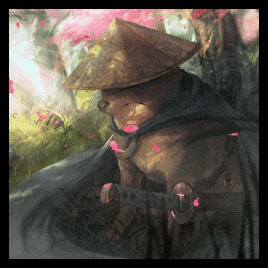

### Выводы и результаты

- Построена двухэтапная модель (поиск `FAISS` и ранжирование с `CatboostClassifier`)
- `FAISS` хорошо работает с расстояниями и скалированными векторами
- Датасет имеет несколько признаков, которые нарушают кластеры, но хорошо разделяют таргеты

`FAISS` искал векторы без "странных признаков"
Классификатор ранжировал результаты со всеми признаками

- Для ранжирования попробованы несколько подходов:
    - обучение на расстояниях до рандомных векторов - слишком простая тренировочная выборка. близкие векторы разделять трудно
    - обучение на расстоях до близких векторов - слишком сложная обучающая выборка
    - обучение на сконкатенированных векторах - результаты хорошие, но недостаточные
    - обучение на сконкатенированных векторах с добавлением расстояний как доп фич - пока что лучшая модель
    
Вывод:
- Не недооценивать важность `EDA`

#### Результат
Метрика acc@5 на валидации на 5 лучших кандидатах из 50 отранжированных составила 75.122

#### Что нужно доделать:
- Поискать иные подходы (возможно, считать разницу между признаками)
- Поэкспериментировать с другими скейлерами, например `QuantileTransformer`
- Попробовать заменить `FAISS` на `Quadrant` или `Annoy`
- Тюнить модель
- Купить больше оперативной памяти =)
